[TFM](https://github.com/jmrplens/TFG-TFM_EPS)

# Diagrama de flujo

<center><img src="Data/Data_flow.svg"/></center>

Metodología
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=294849

# Métodos

## Carga Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Versión y especificación de directorios

In [2]:
from datetime import datetime

MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")


WEIGHTS_PATH  = './feature_weights/'
REPORTS_PATH  = 'Reports/'
MODELS_PATH   = 'Models/'
F1_SCORES_PATH = 'F1scores/'
GA_SCORES_PATH = 'GA_Scores/'
HYPERPARAMS_PATH = './hyperparams/'

HYPERPARAMS_EVOLUTON_PATH = './hyperparams_evolution/'
FINAL_POPULATION_PATH  = './population/'
CONFUSIONS_MATRIX_PATH = 'confusion_matrix/'

###### MODELS ######
MODELS_NAME = ['knn', 'convolution_1d', 'convolution_2d']

REPORTS_SUMMARY_PATH = f"{REPORTS_PATH}summary/"

## Importar Tensorflow

In [3]:
# !pip install tensorflow-addons

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, BatchNormalization, Add, concatenate, Conv2DTranspose, Flatten

2022-05-12 08:40:11.783402: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

Found GPU at: /device:GPU:0
Thu May 12 08:40:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P0    N/A /  N/A |    172MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

2022-05-12 08:40:14.527313: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-12 08:40:14.531281: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-12 08:40:14.565647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 08:40:14.565993: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-05-1

## Importador/Exportador JSON

In [6]:
import json

def write_json(feature_vector, root_path, file_name):
    with open(root_path + file_name, 'w') as outfile:
        json.dump(feature_vector, outfile)

def load_json(root_path, file_name):
    with open(root_path + file_name) as json_file:
        data = json.load(json_file)

    return data

## Construcción de imágenes

In [7]:
import numpy as np
import math
from matplotlib import pyplot as plt

def get_feature_matrix_indexes(sorted_feature_vector,matrix):  

    half_row = round((matrix.shape[0] - 1) / 2)
    half_column = round((matrix.shape[1] - 1) / 2)

    matrix_indexes = {}
    
    index = 0

    for parent_key in sorted_feature_vector:
        normalized_index = math.ceil(index/2)

        if (index % 2 != 0): # Impar
            current_row = half_row - normalized_index
        else: # Par
            current_row = half_row + normalized_index

        sorted_child_indexes = np.argsort(feature_vector[parent_key]['feature_weights'])[::-1]

        child_names   = np.array(feature_vector[parent_key]['feature_childs'])
        child_weights = np.array(feature_vector[parent_key]['feature_weights'])

        sorted_child_names   = child_names[sorted_child_indexes]
        sorted_child_weights = child_weights[sorted_child_indexes]

        position = 0
        for sorted_child_index in sorted_child_indexes:
            normalized_position = math.ceil(position/2)

            if (position % 2 != 0): # Impar
                current_column = half_column - normalized_position
            else: # Par
                current_column = half_column + normalized_position

            matrix_indexes[child_names[sorted_child_index]] = [current_row, current_column]
            position = position + 1 

        index = index + 1

    return matrix_indexes
    
def fv2gi(feature_vector):

    max_dimension = 0
    for key in feature_vector:
        childs_number = len(feature_vector[key]['feature_childs'])
        max_dimension = max(childs_number, max_dimension)
                
    matrix = np.zeros((max_dimension, max_dimension))

    weights_vector = []
    for parent_key in feature_vector:
        wpi = sum([float(child_weight) for child_weight in feature_vector[parent_key]['feature_weights']])
        feature_vector[parent_key]['wpi'] = wpi
        weights_vector.append(wpi)

   
    sorted_feature_vector = sorted(feature_vector.items(),
                                   key = lambda item: item[1]['wpi'],
                                   reverse = True)
     
    sorted_feature_vector = dict(sorted_feature_vector)

    
    matrix_indexes = get_feature_matrix_indexes(sorted_feature_vector, matrix)

    return matrix_indexes

# matrix_indexes = fv2gi(feature_vector)

## Construcción Feature Vector

In [8]:
def fill_feature_vector(X_dataset,child_weights):
  # Obtenemos el set de columnas del dataset
  train_columns_set  = set(X_dataset.columns)

  for parent_feature in feature_vector.keys():
    # Obtiene el set de características hijas del padre actual
    # dict.fromleys para mantener el orden, un set desordena los valores
    feature_childs_set = dict.fromkeys(feature_vector[parent_feature]['feature_childs'])

    # Obtener el índice de las columnas del actual padre para acceder a los pesos del XGBoost
    index_feature_childs = X_dataset.columns.get_indexer(feature_childs_set)

    feature_vector[parent_feature]['feature_weights'] = list([str(child_weight) for child_weight in child_weights[index_feature_childs]])

  return feature_vector

## Normalización de datos

In [9]:
from scipy.stats import zscore
import pandas as pd

def normalize_data(X_data):

    # Create a sample df
    normalized_df = X_data

    # Calculate the zscores and drop zscores into new column
    for column in normalized_df.columns:
        normalized_df[column] = zscore(normalized_df[column])
    
    return normalized_df

## Oversampling de datos

In [10]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import KMeansSMOTE

def oversample_data(X_data, Y_labels):

    oversampler = BorderlineSMOTE(kind='borderline-2')
    # oversampler = RandomOverSampler()
    # oversampler = KMeansSMOTE()
    X_oversampled, Y_oversampled = oversampler.fit_resample(X_data, Y_labels)

    print('********** After OverSampling **********')
    print('Slight: ', (Y_oversampled == 'Slight').sum())
    print('Serious:', (Y_oversampled == 'Serious').sum())
    print('Fatal:  ', (Y_oversampled == 'Fatal').sum())
    print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled))

    return X_oversampled, Y_oversampled

## Construcción de imágenes

In [11]:
def build_gray_images(dataset, max_dimension, matrix_indexes):

    matrix_3d = np.zeros((max_dimension, max_dimension, len(dataset.index)))
    print(len(dataset.index))
    for feature, value in matrix_indexes.items():
        matrix_3d[value[0], value[1],] = dataset[feature]
        
    return matrix_3d

## Algoritmo genético

### Inicializar población

In [12]:
def generate_individual(hyperparams_to_optimize):

    individual = []

    for key in hyperparams_to_optimize:
        min_value = hyperparams_to_optimize[key]['init'][0]
        max_value = hyperparams_to_optimize[key]['init'][1]
        data_type = hyperparams_to_optimize[key]['type']
        
        if data_type == 'int':
            step = hyperparams_to_optimize[key]['step']
            hyperparam = int(random.randrange(min_value, max_value))

        if data_type == 'float':
            round_to = hyperparams_to_optimize[key]['round']
            hyperparam = round(random.uniform(min_value, max_value), round_to)

        individual.append(hyperparam)
    
    return individual

def initilialize_population(number_of_individuals, hyperparams_to_optimize):
    population = []

    for i in range(number_of_individuals):

        population.append(generate_individual(hyperparams_to_optimize))
      
    return np.array(population)

### Fitness function

In [13]:
from sklearn.metrics import f1_score

def fitness_f1score(y_true, y_pred):

    fitness = round((f1_score(y_true, y_pred, average='micro')), 4)

    return fitness # Train the data annd find fitness score

### Evaluación de población

In [14]:
from xgboost import XGBClassifier
import xgboost as xgb
import time

def train_population(population, hyperparams_to_optimize, dMatrixTrain, dMatrixTest, Y_test):
    fScore = []
    
    params = {'objective':'multi:softprob',
               'tree_method': 'gpu_hist',
               'single_precision_histogram': True,
               'num_class': 3
             }

    for individual_index in range(population.shape[0]):
        # Se almacenan en hyperparams_to_optimize los valores del individuo con su nombre correspondiente de hyperparams_name_to_optimize.
        hyperparams = {}

        for index, hyperparam_value in enumerate(population[individual_index]):

            hyperparam_name_to_optimize = list(hyperparams_to_optimize.keys())[index]
            data_type = hyperparams_to_optimize[hyperparam_name_to_optimize]['type']

            hyperparams[hyperparam_name_to_optimize] = hyperparam_value
            hyperparams[hyperparam_name_to_optimize] = hyperparams[hyperparam_name_to_optimize].astype(data_type)
        
        params.update(hyperparams)

        num_round = params['n_estimators']
        
        start = time.time()

        xgb.set_config(verbosity=0)
        bst = xgb.train(params,
                        dMatrixTrain,
                        num_round)

        end = time.time()

        preds = bst.predict(dMatrixTest)
        
        single_predictions = [np.argmax(pred) for pred in preds]
        # preds = preds > 0.5

        fitness_score = fitness_f1score(Y_test, single_predictions)

        # print(f"{individual_index}: {hyperparams} --> time(s): {round(end - start, 2)} --> score: {fitness_score}")

        fScore.append(fitness_score)

    return fScore

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Selección de padres

In [15]:
# Select parents for mating
def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) # Create an array to store fittest parents.

    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 # Set this value to negative, in case of F1-score, so this parent is not selected again

    return selectedParents

### Cruzamiento de población

In [16]:
'''
Mate these parents to create children having parameters from these parents (we are using uniform crossover method)
'''
def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex  = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) # get all the index
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
    children = np.empty(childrenSize)
    
    '''
    Create child by choosing parameters from two parents selected using new_parent_selection function. The parameter values
    will be picked from the indexes, which were randomly selected above. 
    '''
    for i in range(childrenSize[0]):
        
        #find parent 1 index 
        parent1_index = i%parents.shape[0]
        #find parent 2 index
        parent2_index = (i+1)%parents.shape[0]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]

    return children

### Mutación

In [17]:
# def mutation(crossover, numberOfParameters):
#     # Define minimum and maximum values allowed for each parameterminMaxValue = np.zeros((numberOfParameters, 2))
#     minMaxValue = np.zeros((numberOfParameters, 2))

#     minMaxValue[0:]  = [0.01, 1.0]  # min/max learning rate
#     minMaxValue[1,:] = [10, 2000]   # min/max n_estimator
#     minMaxValue[2,:] = [1, 20]      # min/max depth
#     minMaxValue[3,:] = [0, 10.0]    # min/max child_weight
#     minMaxValue[4,:] = [0.01, 10.0] # min/max gamma
#     minMaxValue[5,:] = [0.01, 1.0]  # min/max subsample
#     minMaxValue[6,:] = [0.01, 1.0]  # min/max colsample_bytree
#     minMaxValue[7,:] = [40.0,180.0] # min/max reg_alpha
#     minMaxValue[8,:] = [0.0, 1.0]   # min/max reg_lambda
 
#     # Mutation changes a single gene in each offspring randomly.
#     mutationValue = 0
#     parameterSelect = np.random.randint(0, numberOfParameters, 1)

#     print(parameterSelect)
# #             if parameterSelect == 0: # learning_rate
# #                 # mutationValue = round(np.random.uniform(-0.2, 0.2), 2)
# #                 mutationValue = round(random.uniform(-0.3, 0.3), 2)
# #             if parameterSelect == 1: # max_depth
# #                 # mutationValue = np.random.randint(-3, 3, 1)
# #                 mutationValue = int(random.randrange(-4, 4, step= 1))
# #             if parameterSelect == 2: # min_child_weight
# #                 # mutationValue = round(np.random.uniform(5, 5), 2)
# #                 mutationValue = round(random.uniform(-5, 5), 1)
#     if parameterSelect == 0: # learning_rate
#         # mutationValue = round(np.random.uniform(-0.2, 0.2), 2)
#         mutationValue = round(random.uniform(-0.2, 0.2), 2)
#     if parameterSelect == 1: # n_estimators
#         mutationValue = np.random.randint(-150, 150, 1)
#         # mutationValue = random.randrange(100, 2000, step = 150)
#     if parameterSelect == 2: # max_depth
#         mutationValue = np.random.randint(-4, 4, 1)
#         # mutationValue = int(random.randrange(1, 20, step= 1))
#     if parameterSelect == 3: # min_child_weight
#         # mutationValue = round(np.random.uniform(5, 5), 2)
#         mutationValue = round(random.uniform(-5, 5), 1)
#     if parameterSelect == 4: #gamma
#         # mutationValue = round(np.random.uniform(-2, 2), 2)
#         mutationValue = round(random.uniform(0.01, 10.0), 2)
#     if parameterSelect == 5: # subsample
#         # mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
#         mutationValue = round(random.uniform(0.01, 1.0), 2)
#     if parameterSelect == 6: # colsample
#         # mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
#         mutationValue = round(random.uniform(0.5, 1.0), 2)
#     if parameterSelect == 7: # reg_alpha
#         # mutationValue = round(np.random.uniform(-20,20), 1)
#         mutationValue = round(random.uniform(40,180), 1)
#     if parameterSelect == 8: # reg_lambda
#         # mutationValue = round(np.random.uniform(-0.2,0.2), 3)
#         mutationValue = round(random.uniform(0,1), 3)
  
#     # Introduce mutation by changing one parameter, and set to max or min if it goes out of range
#     for idx in range(crossover.shape[0]):
#         crossover[idx, parameterSelect] = crossover[idx, parameterSelect] + mutationValue

#         if(crossover[idx, parameterSelect] > minMaxValue[parameterSelect, 1]):
#             crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 1]

#         if(crossover[idx, parameterSelect] < minMaxValue[parameterSelect, 0]):
#             crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 0]

#     return crossover

In [18]:
def mutation(crossover, hyperparams_to_optimize):
    
    # MUTATION_PROBABILITY = 1/numberOfParameters
    
    MUTATION_PROBABILITY = 0.2
    number_of_parameters = len(hyperparams_to_optimize)

    for idx in range(crossover.shape[0]):

        mutation_probability = np.random.rand(1)

        while MUTATION_PROBABILITY > mutation_probability:

            mutationValue = 0

            hyperparam_selected_index = np.random.randint(0, number_of_parameters)
            hyperparam_selected_name  = list(hyperparams_to_optimize.keys())[hyperparam_selected_index]

            min_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][0]
            max_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][1]

            min_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][0]
            max_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][1]

            data_type = hyperparams_to_optimize[hyperparam_selected_name]['type']
            
            if data_type == 'int':
                step = hyperparams_to_optimize[hyperparam_selected_name]['step']
                mutationValue = int(random.randrange(min_mutation_value, max_mutation_value, step = step))

            if data_type == 'float':
                round_to = hyperparams_to_optimize[hyperparam_selected_name]['round']
                mutationValue = round(random.uniform(min_mutation_value, max_mutation_value), round_to)
                
            print(idx, hyperparam_selected_name, mutationValue)

            crossover[idx, hyperparam_selected_index] = crossover[idx,hyperparam_selected_index] + mutationValue

            if(crossover[idx, hyperparam_selected_index] > max_limit_value):
                crossover[idx, hyperparam_selected_index] = max_limit_value

            if(crossover[idx, hyperparam_selected_index] < min_limit_value):
                crossover[idx, hyperparam_selected_index] = min_limit_value
                
            mutation_probability = np.random.rand(1)


    return crossover

## Reshape de imágenes

In [19]:
# Add one channel
# https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

# Add one channel to gray images depending of the number of the data
def shape_images(X_data, gray_images):
  images = []

  for i in range(0,len(X_data)):
      original_matrix = gray_images[:,:,i]
      # print(original_matrix.shape)
      shaped_image = np.expand_dims(original_matrix, axis=2)
      # print(shaped_image.shape)
      images.append(shaped_image)
      # plt.matshow(shaped_image)

  return images

## One-Hot Encoder/Decoder

In [20]:
def casualty_to_one_hot(Y_labels):

    transf = {
        'Slight': 0,
        'Serious': 1,
        'Fatal': 2
    }

    Y_labels.replace(transf, inplace = True)

    return tf.one_hot(Y_labels, 3)

def one_hot_to_casualty(Y_labels):

    transf = {
        0: 'Slight',
        1: 'Serious',
        2: 'Fatal'
    }   

    return Y_labels.replace(transf)

## Visualización de datos

### Matriz de correlación

In [21]:
import seaborn as sns

def correlation_matrix(X_data):
    corrMatrix = X_data.corr()
    fig,ax  = plt.subplots(1,1,figsize=(20,15))
    sns.heatmap(corrMatrix, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()


### PCA

In [56]:
from sklearn.decomposition import PCA

def pca(X_train_data, X_test_data):
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_data)
    X_test_pca  = pca.transform(X_test_data)
    explained_variance = pca.explained_variance_ratio_

    figure_name = plt.figure(figsize=(20, 15))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()

### TSNE

In [23]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_TSNE(X_data, Y_data, n_components, output_file_name = None):

    X_data_scaled = StandardScaler().fit_transform(X_data)
    z_data = TSNE(n_components = n_components).fit_transform(X_data_scaled)

    # X_test_scaled = StandardScaler().fit_transform(X_test),
    # z_test = TSNE(n_components=2).fit_transform(X_test_scaled),

    palette = sns.color_palette('husl', 3)
    fig,ax  = plt.subplots(1, 1, figsize=(15,10))
    sns.scatterplot(x = z_data[:,0],
                    y = z_data[:,1],
                    hue = Y_data,
                    palette = palette,
                    legend = 'full')

    if (output_file_name): plt.savefig('./Out/' + output_file_name)

### Autoencoder

In [24]:
def autoencoder ():
    input_img = Input(shape=(25,))

    # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
    encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
    encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

    # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
    decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
    decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

    # this model maps an input to its reconstruction
    autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
    autoencoder.summary()

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy') #se usan estos dos en estas arquitecturas
    
    return autoencoder

## 1D-Convolution

In [25]:
import tensorflow_addons as tfa

lr_init = 0.1
num_classes = 3

convolution_1d = models.Sequential()
convolution_1d.add(layers.Conv1D(256, 3,strides = 1, activation='relu', padding='same', input_shape=(5, 5, 1)))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same', input_shape=(3, 3, 256)))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same', input_shape=(3, 3, 256)))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same', input_shape=(3, 3, 256)))
convolution_1d.add(layers.BatchNormalization())  
convolution_1d.add(layers.Flatten())
convolution_1d.add(layers.Dense(units=128))
convolution_1d.add(layers.Dense(num_classes, activation='softmax'))

convolution_1d.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='categorical_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2022-05-12 08:40:18.882340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 08:40:18.882532: I tensorflow/co

## TASP-CNN

In [26]:
lr_init = 0.1
num_classes = 3

tasp_cnn = models.Sequential()
tasp_cnn.add(layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 256)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 256)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 256)))
tasp_cnn.add(layers.BatchNormalization())  
tasp_cnn.add(layers.Flatten())
tasp_cnn.add(layers.Dense(units=128))
tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

tasp_cnn.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='categorical_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )

In [27]:
tasp_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 5, 256)         2560      
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 256)         590080    
_________________________________________________________________
batch_normalization_5 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 256)         590080    
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 256)        

In [28]:
print('Done!')

Done!


# Leeds Data

## Importación de datos

In [29]:
# !conda install pandas --y

In [30]:
import pandas as pd
# https://datamillnorth.org/dataset/road-traffic-accidents
# root_path = '/content/drive/Othercomputers/Mi portátil/Drive/Master UA/TFM/TFM_DATA/'

root_path = './Data/Leeds/'

file_path_2009 = './2009.csv'
file_path_2010 = './2010.csv'
file_path_2011 = './2011.csv'
file_path_2012 = './2012.csv'
file_path_2013 = './2013.csv'
file_path_2014 = './2014.csv'
file_path_2015 = './2015.csv'
file_path_2016 = './2016.csv'

file_2009 = pd.read_csv(root_path + file_path_2009, encoding = 'cp1252')
file_2010 = pd.read_csv(root_path + file_path_2010, encoding = 'cp1252')
file_2011 = pd.read_csv(root_path + file_path_2011, encoding = 'cp1252')
file_2012 = pd.read_csv(root_path + file_path_2012, encoding = 'cp1252')
file_2013 = pd.read_csv(root_path + file_path_2013, encoding = 'cp1252')
file_2014 = pd.read_csv(root_path + file_path_2014, encoding = 'cp1252')
file_2015 = pd.read_csv(root_path + file_path_2015, encoding = 'cp1252')
file_2016 = pd.read_csv(root_path + file_path_2016, encoding = 'cp1252')

###################### UNIÓN DE ARCHIVOS ######################

a = pd.concat([file_2009,file_2010])

file_2013 = clean_df = file_2013.loc[:, ~file_2013.columns.isin(['Casualty Class'])]
file_2013.set_axis(a.columns, axis=1, inplace=True)
                                             
file_2014 = clean_df = file_2014.loc[:, ~file_2014.columns.isin(['Casualty Class'])]
file_2014.set_axis(a.columns, axis=1, inplace=True)

# file_2015 = clean_df = file_2015.loc[:, ~file_2015.columns.isin(['Casualty Class'])]
file_2015.set_axis(a.columns, axis=1, inplace=True)
file_2016 = clean_df = file_2016.loc[:, ~file_2016.columns.isin(['Expr1'])]
file_2016.set_axis(a.columns, axis=1, inplace=True)

a = pd.concat([a, file_2011])
a = pd.concat([a, file_2012])
a = pd.concat([a, file_2013])
a = pd.concat([a, file_2014])
a = pd.concat([a, file_2015])
a = pd.concat([a, file_2016])

# a['1st Road Class'].value_counts()

## Limpieza de datos

In [31]:
###################### DICCIONARIOS DE REEMPLAZO ######################
# Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# A, A(M) y Motorway lo mismo?
# B:            De carácter regional y utilizado para conectar zonas de menor importancia.
#               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
#               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
#               ¿Carretera como tal?

# C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
#               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.
road_class_replace = {
    'Motorway': 1,
    'A(M)': 2,
    'A': 3,
    'B': 4,
    'C': 5,
    'Unclassified': 6
}

##################################
accident_date_replace = {
    'Dry': 1,
    'Wet / Damp': 2,
    'Snow': 3,
    'Frost / Ice': 4,
    'Flood': 5,
}
##################################

road_surface_replace = {
    'Dry': 1,
    'Wet / Damp': 2,
    'Snow': 3,
    'Frost/ Ice': 4,
    'Frost / Ice': 4,
    'Flood': 5,
    'Flood (surface water over 3cm deep)': 5,
    '5': 5
}

# La 5: "Darkness: street lighting unknown" no está presente en el paper, le hemos puesto un 5 porque sí #
lighting_conditions_replace = {
    'Daylight: street lights present': 1,
    'Darkness: no street lighting': 2,
    'Darkness: street lights present and lit': 3,
    'Darkness: street lights present but unlit': 4,
    'Darkness: street lighting unknown': 5,
    '5': 5
}

# La 8.2: "Unknown" no está presente en el paper, le hemos puesto un 8 porque sí (Other) #
weather_conditions_replace = {
    'Fine without high winds': 1,
    'Raining without high winds': 2,
    'Snowing without high winds': 3,
    'Fine with high winds': 4,
    'Raining with high winds': 5,
    'Snowing with high winds': 6,
    'Fog or mist – if hazard': 7,
    'Other': 8,
    'Unknown': 8
}

type_of_vehicle_replace = {
    'Pedal cycle': 1,
    'M/cycle 50cc and under': 2,
    'Motorcycle over 50cc and up to 125cc': 3,
    'Motorcycle over 125cc and up to 500cc': 4,
    'Motorcycle over 500cc': 5,
    'Taxi/Private hire car': 6,
    'Car': 7,
    'Minibus (8 – 16 passenger seats)': 8,
    'Bus or coach (17 or more passenger seats)': 9,
    'Ridden horse': 10,
    'Agricultural vehicle (includes diggers etc.)': 11,
    'Tram / Light rail': 12,
    'Goods vehicle 3.5 tonnes mgw and under': 13,
    'Goods vehicle over 3.5 tonnes and under 7.5 tonnes mgw': 14,
    'Goods vehicle 7.5 tonnes mgw and over': 15,
    'Mobility Scooter': 16,
    'Other Vehicle ': 17,
    'Motorcycle - Unknown CC': 18
}

casualty_class_replace = {
    'Driver': 1,
    'Driver/Rider': 1,
    'Driver or rider': 1,
    'Passenger': 2,
    'Vehicle or pillion passenger': 2,
    'Pedestrian': 3
}


sex_of_casualty_replace = {
    'Male': 1,
    'Female': 2
}

###################### REEMPLAZOS ######################
clean_df = clean_df.dropna()

a['1st Road Class'].replace(road_class_replace, inplace = True)
# print('1st Road Class:', a['1st Road Class'].unique())

##################################
# a['Accident Date'].replace(accident_date_replace, inplace = True)
# print('Accident Date:', a['Accident Date'].unique())
##################################
a['Road Surface'].replace(road_surface_replace, inplace = True)
a.dropna(inplace = True)

a['Road Surface'] = a['Road Surface'].astype('int')
# print('Road Surface:', a['Road Surface'].unique())

a['Lighting Conditions'].replace(lighting_conditions_replace, inplace = True)
# print('Lighting Conditions:', a['Lighting Conditions'].unique())

a['Weather Conditions'].replace(weather_conditions_replace, inplace = True)
a = a[a['Weather Conditions'] != 'Darkness: street lighting unknown']
# print('Weather Conditions:', a['Weather Conditions'].unique())

a['Type of Vehicle'].replace(type_of_vehicle_replace, inplace = True)
# print('Type of Vehicle:', a['Type of Vehicle'].unique())

a['Casualty Class'].replace(casualty_class_replace, inplace = True)
# print('Casualty Class:', a['Casualty Class'].unique())

a['Sex of Casualty'].replace(sex_of_casualty_replace, inplace = True)
# print('Sex of Casualty:', a['Sex of Casualty'].unique())

a['Age of Casualty'] = a['Age of Casualty'].mask(a['Age of Casualty'] < 18, 1)
a['Age of Casualty'] = a['Age of Casualty'].mask(a['Age of Casualty'].between(18, 25), 2)
a['Age of Casualty'] = a['Age of Casualty'].mask(a['Age of Casualty'].between(25, 65), 3)
a['Age of Casualty'] = a['Age of Casualty'].mask(a['Age of Casualty'] > 65, 4)
# print('Age of Casualty:', a['Age of Casualty'].unique())

a['Time (24hr)'] = a['Time (24hr)'].mask(a['Time (24hr)'] < 600, 2)
a['Time (24hr)'] = a['Time (24hr)'].mask(a['Time (24hr)'] > 1800, 2)
a['Time (24hr)'] = a['Time (24hr)'].mask(a['Time (24hr)'].between(600, 1800), 1)
# print('Time (24hr):', a['Time (24hr)'].unique())
a.rename(columns={"Time (24hr)": "Accident Time"}, inplace = True)

###################### LIMPIEZA DE VALORES NULOS/DUPLICADOS ######################

clean_df = a.loc[:, ~a.columns.isin(['Accident Date', 'Reference Number'])]

clean_df['Weather Conditions'] = clean_df['Weather Conditions'].astype('int')
clean_df['Casualty Class']     = clean_df['Casualty Class'].astype('int')

clean_df = clean_df.drop_duplicates()
clean_df = clean_df.dropna()
clean_df = clean_df.reset_index(drop=True)

clean_df

/tmp/ipykernel_6848/4205016787.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Weather Conditions'] = clean_df['Weather Conditions'].astype('int')
/tmp/ipykernel_6848/4205016787.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Casualty Class']     = clean_df['Casualty Class'].astype('int')


,Easting,Northing,Number of Vehicles,Accident Time,1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle
0,429093,436258,1,2,6,1,3,1,3,Slight,1,3,7
1,434723,435534,1,2,6,1,3,1,1,Serious,2,2,7
2,441173,433047,1,1,6,1,3,1,3,Slight,2,1,7
3,428487,431364,1,1,3,1,3,1,3,Slight,1,1,7
4,425928,435480,2,1,6,1,1,1,1,Slight,2,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20302,423815,434248,2,2,6,2,3,1,1,Slight,1,3,3
20303,427102,427700,2,2,6,2,3,1,1,Slight,2,3,7
20304,419983,440944,2,1,3,1,3,1,1,Serious,2,3,7
20305,419983,440944,2,1,3,1,3,1,3,Slight,1,3,7


## Split de datos

In [32]:
# !conda install scikit-learn --y

In [33]:
from sklearn.model_selection import train_test_split

Y = clean_df['Casualty Severity']

train, test = train_test_split(clean_df, test_size=0.2)
X_train = train.loc[:, ~train.columns.isin(['Casualty Severity'])]
Y_train = train['Casualty Severity']

X_test = test.loc[:, ~test.columns.isin(['Casualty Severity'])]
Y_test = test['Casualty Severity']

### Downsampling

In [34]:
from sklearn.model_selection import train_test_split

Y = clean_df['Casualty Severity']

from sklearn.utils import resample

slight_data  = test[test['Casualty Severity'] == 'Slight']
serious_data = test[test['Casualty Severity'] == 'Serious']
fatal_data   = test[test['Casualty Severity'] == 'Fatal']

X_slight_downsampled  = resample(slight_data,
                                 replace = True,
                                 n_samples = len(fatal_data))

X_serious_downsampled = resample(serious_data,
                                 replace = True,
                                 n_samples = len(fatal_data))

downsampled_dataset = pd.concat([X_slight_downsampled, X_serious_downsampled, fatal_data])

downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.3)


X_train_downsampled = downsampled_train.loc[:, ~downsampled_train.columns.isin(['Casualty Severity'])]
Y_train_downsampled = downsampled_train['Casualty Severity']

X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin(['Casualty Severity'])]
Y_test_downsampled = downsampled_test['Casualty Severity']

In [35]:
# fv2gi(feature_vector)
# sorted(feature_vector.items(), key = lambda item: item[0][1])

# for item in feature_vector['Accident Features'].items():
#     print(item[1])

# feature_vector[parent_key].items()

# sorted(feature_vector['Accident Features'].items(), key = lambda item: item,
#                                reverse = True)

# print(feature_vector['Accident Features']['feature_weights'])

# fv = np.array(feature_vector['Accident Features']['feature_childs'])
# list(fv[indexes])

## Normalización de datos

In [36]:
# !conda install -c conda-forge imbalanced-learn

In [37]:
X_train = X_train.astype(int)
X_test  = X_test.astype(int)
X_train_downsampled = X_train_downsampled.astype(int)
X_test_downsampled  = X_test_downsampled.astype(int)

X_train = normalize_data(X_train)
X_test  = normalize_data(X_test)
X_train_downsampled = normalize_data(X_train_downsampled)
X_test_downsampled  = normalize_data(X_test_downsampled)

## Oversamplig de datos

In [38]:
print('********** Before OverSampling **********')
print('Slight: ', (Y_train == 'Slight').sum())
print('Serious:', (Y_train == 'Serious').sum())
print('Fatal:  ', (Y_train == 'Fatal').sum())
print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

X_train, Y_train = oversample_data(X_train, Y_train)

********** Before OverSampling **********
Slight:  14269
Serious: 1876
Fatal:   100

 Total X: 16245  Total Y: 16245 

********** After OverSampling **********
Slight:  14269
Serious: 14268
Fatal:   14269

 Total X:  42806  Total Y:  42806


## XGBoost

In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Genético

In [376]:
HYPERPARAMS_TO_OPTIMIZE = {'eta': {'type': 'float',
                                   'init': [0.01, 1],
                                   'mutation': [-0.3, 0.3],
                                   'round': 2
                                   },
                           'max_depth': {'type': 'int',
                                         'init': [1, 25],
                                         'mutation': [-6, 6],
                                         'step': 1
                                   },
                           'min_child_weight': {'type': 'float',
                                                'init': [0.01, 20.0],
                                                'mutation': [-7, 7],
                                                'round': 1
                                   },
                           'n_estimators': {'type': 'int',
                                            'init': [0, 1500],
                                            'mutation': [-150, 150],
                                            'step': 25
                                   },
                           # 'gamma': {'type': 'float',
                           #                   'init': [0.01, 10.0],
                           #                   'mutation': [-4, 4],
                           #                   'round': 2
                           #         },
                           # 'subsample': {'type': 'float', ## ATTENTION! SUBSAMPLE OF TRAINING
                           #               'init': [0.01, 1],
                           #               'mutation': [-0.4, 0.4],
                           #               'round': 2
                           #         },
                           # 'colsample_bytree': {'type': 'float', ## ATENTION!! SUBSAMPLE OF COLUMNS
                           #               'init': [0.01, 1],
                           #               'mutation': [-0.4, 0.4],
                           #               'round': 2
                           #         },
                           # 'reg_alpha': {'type': 'float', ## ATENTION!! MODEL MORE CONSERVATIVE!
                           #               'init': [0, 1],
                           #               'mutation': [-0.4, 0.4],
                           #               'round': 2
                           #         },
                           # 'reg_lambda': {'type': 'float', ## ATENTION!! MODEL MORE CONSERVATIVE!
                           #               'init': [0, 1],
                           #               'mutation': [-0.4, 0.4],
                           #               'round': 2
                           #         }
                          }

In [377]:
# import xgboost as xgb
# import random

# Y_train_onehot = casualty_to_one_hot(Y_train)
# Y_test_onehot  = casualty_to_one_hot(Y_test)

# Y_train_downsampled_onehot = casualty_to_one_hot(Y_train_downsampled)
# Y_test_downsampled_onehot  = casualty_to_one_hot(Y_test_downsampled)


# number_of_individuals = 100
# numberOfParentsMating = 35
# number_of_hyperparams = len(HYPERPARAMS_TO_OPTIMIZE)
# number_of_generations = 100

# populationSize = (number_of_individuals, number_of_hyperparams)
# population = initilialize_population(number_of_individuals   = number_of_individuals,
#                                      hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

# fitnessHistory = np.empty([number_of_generations+1, number_of_individuals]) # Define an array to store the value of each parameter for each parent and generation
# populationHistory = np.empty([(number_of_generations+1)*number_of_individuals, number_of_hyperparams]) # Insert the value of initial parameters in history

# best_solution_history = np.empty([(number_of_generations), number_of_hyperparams+1])
# populationHistory[0:number_of_individuals,:] = population


# xgbDMatrixTrain = xgb.DMatrix(data  = X_train_downsampled,
#                               label = Y_train_downsampled)

# xgbDMatrixTest  = xgb.DMatrix(data  = X_test_downsampled, 
#                               label = Y_test_downsampled)

# for generation in range(number_of_generations):

#     print("This is number %s generation" % (generation))

#     new_population = []
    
#     unique_individuals = np.unique(population, axis=0)
    
#     new_individuals_to_create = number_of_individuals - len(unique_individuals)
    
#     for i in range(new_individuals_to_create):
#         new_individual = generate_individual(hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)
#         new_population.append(new_individual)
    
#     new_population = np.array(new_population)

#     if (new_individuals_to_create):
#         population = np.concatenate((unique_individuals, new_population), axis=0)

#     # print(f'Current population is {population}')
#     print(f'New population is {len(new_population)}')
    
#     # Train the dataset and obtain fitness
#     fitnessValue = train_population(population = population,
#                                     hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
#                                     dMatrixTrain = xgbDMatrixTrain,
#                                     dMatrixTest = xgbDMatrixTest,
#                                     Y_test = Y_test_downsampled)
 
#     fitnessHistory[generation,:] = fitnessValue

#     # Best score in the current iteration
#     max_score_index = np.argmax(fitnessHistory[generation,:])
#     max_score_value = np.max(fitnessHistory[generation,:])
#     max_score_solution = population[max_score_index]

#     max_solution_with_score = []
#     max_solution_with_score = np.append(max_score_solution, max_score_value)
#     best_solution_history[generation] = max_solution_with_score

#     print(f"Best F1 score in the this iteration = {max_score_value}, best solution {max_score_solution}") # Survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected
    
#     parents = new_parents_selection(population = population,
#                                     fitness = fitnessValue,
#                                     numParents = numberOfParentsMating)
    
#     # Mate these parents to create children having parameters from these parents (we are using uniform crossover)
#     children = crossover_uniform(parents = parents,
#                                  childrenSize = (populationSize[0] - parents.shape[0], number_of_hyperparams))
    
#     # Add mutation to create genetic diversity
#     children_mutated = mutation(children,
#                                 hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)
    
#     '''
#     We will create new population, which will contain parents that where selected previously based on the
#     fitness score and rest of them  will be children
#     '''
#     population[0:parents.shape[0], :] = parents # Fittest parents
#     population[parents.shape[0]:, :]  = children_mutated # Children
    
#     populationHistory[(generation+1)*number_of_individuals : (generation+1)*number_of_individuals + number_of_individuals , :] = population # Store parent information
    
# #Best solution from the final iteration

# fitness = train_population(population = population,
#                            hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
#                            dMatrixTrain = xgbDMatrixTrain,
#                            dMatrixTest = xgbDMatrixTest,
#                            Y_test = Y_test_downsampled)

# fitnessHistory[generation+1, :] = fitness # index of the best solution
# bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]


# best_hyperparams = {}
# for n_param, hyperparam in enumerate(HYPERPARAMS_TO_OPTIMIZE):
#     best_hyperparams[hyperparam] = population[bestFitnessIndex][n_param]

In [378]:
# #### PLOT FITNESS EVOLUTION ####
# x_fitness = [np.max(fitnessHistory[i]) for i in range(0,fitnessHistory.shape[0])]

# FILE_NAME = 'leeds_ga_' + MODEL_TIMESTAMP  + '.jpg'

# plt.figure(figsize=(10, 5))
# plt.plot(np.arange(len(x_fitness)), x_fitness)
# plt.savefig(GA_SCORES_PATH + FILE_NAME)

# #### PLOT HYPERPARAMS EVOLUTION ####
# FILE_NAME = f"leeds_ga_hyperparams_evolution_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.jpg"

# LEGEND_LABELS = HYPERPARAMS_TO_OPTIMIZE.keys()

# plt.figure(figsize=(15, 8))
# best_solution_history_aux = best_solution_history
# best_solution_history_aux[:,1] = best_solution_history[:,1]/2
# best_solution_history_aux[:,3] = best_solution_history[:,3]/100
# plt.plot(best_solution_history_aux)
# plt.legend(LEGEND_LABELS)
# plt.savefig(HYPERPARAMS_EVOLUTON_PATH +  'TEST.jpg', dpi=300)

# FILE_NAME = f"leeds_population_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.txt"

# np.savetxt(FINAL_POPULATION_PATH + FILE_NAME, population, fmt='%s')

### Hiperparámetros

#### Carga hiperparámetros

In [379]:
FILE_NAME = 'leeds_hyperparams_2022-04-28-19:07:55.json'

best_hyperparams = load_json(HYPERPARAMS_PATH, FILE_NAME)

# # # 0.04 2 6.5 --> 0.778
# best_hyperparams = {}
# best_hyperparams['eta'] = 0.1
# best_hyperparams['max_depth'] = 2
# best_hyperparams['min_child_weight'] = 1
# best_hyperparams['n_estimators'] = 583

# 1.00e-01 2.00e+00 1.00e+00 5.83e+02 --> 0.72

#### Cálculo de Hiperparámetros

In [380]:
# Y_train_onehot = casualty_to_one_hot(Y_train)
# Y_test_onehot  = casualty_to_one_hot(Y_test)

# space={'max_depth': hp.quniform("max_depth", 3, 25, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 15, 1),
#         'n_estimators': hp.quniform('n_estimators', 100, 4000, 100),
#         'tree_method': 'gpu_hist'
#     }

# def objective(space):
#     clf = XGBClassifier(n_estimators = int(space['n_estimators']),
#                         max_depth = int(space['max_depth']),
#                         gamma = space['gamma'],
#                         reg_alpha = int(space['reg_alpha']),
#                         min_child_weight = int(space['min_child_weight']),
#                         colsample_bytree = int(space['colsample_bytree']),
#                         tree_method = space['tree_method']
#                        )
    
#     evaluation = [(X_train, Y_train), (X_test, Y_test)]
    
#     clf.fit(X_train, Y_train,
#             eval_set = evaluation, eval_metric = "auc",
#             early_stopping_rounds = 10, verbose = False)
            
    
#     pred = clf.predict(X_test)
#     accuracy = accuracy_score(Y_test, pred>0.5)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }


# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

#### Escritura hiperparámetros

In [381]:
# FILE_NAME = f"leeds_hyperparams_{MODEL_TIMESTAMP}.json"

# write_json(best_hyperparams, HYPERPARAMS_PATH, FILE_NAME)

### Pesos de características

#### Carga definitiva/auxiliar de pesos

In [382]:
# FILE_NAME = 'leeds_calculated_weights.json'
FILE_NAME = 'leeds_weights2022-04-14-10:55:09.json'

feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)

#### Cálculo de pesos de caracetrísticas

In [383]:
from numpy import loadtxt
from xgboost import XGBClassifier,XGBRanker
from matplotlib import pyplot
from xgboost import plot_importance

xgboost = XGBClassifier(best_hyperparams,
                        tree_method = 'gpu_hist',
                        single_precision_histogram =  True)

xgboost.fit(X_train, Y_train)

child_weights  = np.array(xgboost.feature_importances_)
feature_vector = fill_feature_vector(X_train, child_weights)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/core.py:499: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBoostError: [19:07:58] ../src/data/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /home/luis/anaconda3/envs/TFM/lib/libxgboost.so(+0x127fa5) [0x7f429cd66fa5]
  [bt] (1) /home/luis/anaconda3/envs/TFM/lib/libxgboost.so(+0x128a8c) [0x7f429cd67a8c]
  [bt] (2) /home/luis/anaconda3/envs/TFM/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xa5) [0x7f429cdcfd75]
  [bt] (3) /home/luis/anaconda3/envs/TFM/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x1f7) [0x7f429cde37c7]
  [bt] (4) /home/luis/anaconda3/envs/TFM/lib/libxgboost.so(+0x1cbf14) [0x7f429ce0af14]
  [bt] (5) /home/luis/anaconda3/envs/TFM/lib/libxgboost.so(+0x1b878d) [0x7f429cdf778d]
  [bt] (6) /home/luis/anaconda3/envs/TFM/lib/libxgboost.so(XGBoosterUpdateOneIter+0x4e) [0x7f429cce2dfe]
  [bt] (7) /home/luis/anaconda3/envs/TFM/lib/python3.9/lib-dynload/../../libffi.so.7(+0x69dd) [0x7f43e92a89dd]
  [bt] (8) /home/luis/anaconda3/envs/TFM/lib/python3.9/lib-dynload/../../libffi.so.7(+0x6067) [0x7f43e92a8067]



#### Visualización pesos calculados

In [ ]:
FILE_NAME = f"leeds_figure_weights_{MODEL_TIMESTAMP}.jpg"

print(xgboost.get_booster().get_score(importance_type= 'weight'))
plt.figure(figsize=(10, 5))
plt.barh(X_train.columns, xgboost.feature_importances_)
plt.savefig(WEIGHTS_PATH + FILE_NAME)

for column, weight in zip(X_train.columns,xgboost.feature_importances_):
  print(column, weight)

#### Escritura de pesos de características

In [ ]:
matrix_indexes = fv2gi(feature_vector)

FILE_NAME = f"leeds_weights_{MODEL_TIMESTAMP}.json"
# FILE_NAME = 'leeds_default_weights.json'

write_json(feature_vector, WEIGHTS_PATH, FILE_NAME)

### Cálculo índices de matriz

In [ ]:
matrix_indexes = fv2gi(feature_vector)

## Construcción de imágenes

In [ ]:
train_bgi = build_gray_images(X_train, 5, matrix_indexes)
test_bgi  = build_gray_images(X_test, 5, matrix_indexes)

pd.DataFrame(train_bgi[:,:,1057])

## Reshape de imágenes

In [ ]:
train_images = shape_images(X_data = X_train,
                            gray_images = train_bgi)
test_images  = shape_images(X_data = X_test,
                            gray_images = test_bgi)

In [ ]:
plt.gray()
for i in range(0,3):
    plt.figure(figsize=(3, 3))
    plt.imshow(train_bgi[:,:,i])
    plt.show()

In [ ]:
# !conda install scikit-image

In [ ]:
# input_shape = (5, 5)

array_train_images = np.asarray(train_images)
array_test_images  = np.asarray(test_images)

In [ ]:
# !conda install -c conda-forge tensorflow 

In [ ]:
######### EN TERMINAL #########
# !pip install tensorflow-addons

## One-Hot

In [ ]:
Y_train_onehot = casualty_to_one_hot(Y_train)
Y_test_onehot  = casualty_to_one_hot(Y_test)

## Visualización de datos

In [ ]:
# !conda install seaborn

### Matriz de correlación

In [ ]:
# correlation_matrix(X_test)

### PCA

In [ ]:
# pca(X_train, X_test)

### TSNE

In [ ]:
# output_file_name = './2d_test_tsne.jpg'
# plot_TSNE(X_test, Y_test, n_components=2)

# output_file_name = './2d_train_tsne.jpg'
# plot_TSNE(X_train, Y_train, n_components=2)

# output_file_name = './3d_test_tsne.jpg'
# plot_TSNE(X_test, Y_test, n_components=3)

# output_file_name = './3d_train_tsne.jpg'
# plot_TSNE(X_train, Y_train, n_components=3)

### Autoencoder

#### Entrenamiento

In [ ]:
X_train = array_train_images
X_test = array_test_images

X_train = X_train.reshape(len(array_train_images), 25)
X_test  = X_test.reshape(len(X_test), 25)

# autoencoder().fit(X_train, X_train,
#                 epochs=15,
#                 batch_size=32,
#                 shuffle=True,
#                 validation_data=(X_test, X_test))

#### Visualización

In [ ]:
# # create encoder model
# encoder = Model(inputs=input_img, outputs=encoder2)
# encoder.summary()
# # create decoder model
# encoded_input = Input(shape=(3,))
# #lo que hace aqui es quedarse con las capas que corresponden al decodificador
# decoder_layer1 = autoencoder.layers[-2]
# decoder_layer2 = autoencoder.layers[-1]
# decoder = Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))
# decoder.summary()
# # si miramos la salida, son simetricos el uno respecto al otro
# # encoder va de input a 3 y decoder de 3 a input

# # get latent vector for visualization
# latent_vector = encoder.predict(X_test)
# # get decoder output to visualize reconstructed image
# reconstructed_imgs = decoder.predict(latent_vector)


# # visualize in 3D plot
# from pylab import rcParams
# from mpl_toolkits.mplot3d import Axes3D

# rcParams['figure.figsize'] = 10, 8

# fig = plt.figure(1)
# ax = Axes3D(fig)

# xs = latent_vector[:, 0]
# ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# color=['red','green','blue']

# for x, y, z, label in zip(xs, ys, zs, Y_test):
#     c = color[int(label)]
#     ax.text(x, y, z, label, backgroundcolor=c)
    
# ax.set_xlim(xs.min(), xs.max())
# ax.set_ylim(ys.min(), ys.max())
# ax.set_zlim(zs.min(), zs.max())

# # plt.show()

# # X_test_encoded = encoder.predict(X_test, batch_size=32)
# # plt.figure(figsize=(6, 6))
# # plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# # plt.colorbar()
# # plt.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_TSNE(X_data, Y_data, n_components, output_file_name=None):
    X_data_scaled = StandardScaler().fit_transform(X_data)
    z_data = TSNE(n_components=n_components).fit_transform(X_data_scaled)
    # X_test_scaled = StandardScaler().fit_transform(X_test)
    # z_test = TSNE(n_components=2).fit_transform(X_test_scaled)

    palette = sns.color_palette("hls", 3)
    fig,ax  = plt.subplots(1,1,figsize=(15,10))
    sns.scatterplot(x = z_data[:,0],
                    y = z_data[:,1],
                    hue = Y_data,
                    palette = palette,
                    legend = 'full')

    if (output_file_name): plt.savefig('./Out/' + output_file_name)

# output_file_name = './2d_test_tsne.jpg'
# plot_TSNE(X_test, Y_test, n_components=2)

# output_file_name = './2d_train_tsne.jpg'
# plot_TSNE(X_train, Y_train, n_components=2)

# output_file_name = './3d_test_tsne.jpg'
# plot_TSNE(X_test, Y_test, n_components=3)

# output_file_name = './3d_train_tsne.jpg'
# plot_TSNE(X_train, Y_train, n_components=3)

## Models

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle

### KNN

In [ ]:
# from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

MODEL_NAME = MODELS_NAME[0]

#### Entrenamiento

In [ ]:
leaf_size = list(range(1,10, 2))
n_neighbors = list(range(1,25, 5))

In [ ]:
# # Create new KNN object
# hyperparameters = dict(leaf_size = leaf_size,
#                        n_neighbors = n_neighbors)

# # Use GridSearch
# knn_2 = KNeighborsClassifier()

# # Fit the model
# clf = GridSearchCV(knn_2,
#                    hyperparameters,
#                    cv = 5)

# knn = clf.fit(X_train, Y_train)

# # Print The value of best Hyperparameters

# best_leaf_size = knn.best_estimator_.get_params()['leaf_size']
# best_n_neighbors = knn.best_estimator_.get_params()['n_neighbors']

# print('Best leaf_size:', best_leaf_size)
# print('Best n_neighbors:', best_n_neighbors)

# df = pd.DataFrame({'best_leaf_size':[best_leaf_size], 'n_neighbors':[best_n_neighbors]})

# FILE_NAME = f"{MODEL_NAME}/leeds_{MODEL_TIMESTAMP}.csv"

# df.to_csv(HYPERPARAMS_PATH + FILE_NAME, index = True)

#### Escritura del modelo

In [ ]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"leeds_{MODEL_NAME}_{MODEL_TIMESTAMP}.pkl"

# # Its important to use binary mode 
# knnPickle = open(MODEL_PATH + MODEL_FILE_NAME, 'wb') 

# # source, destination 
# pickle.dump(knn, knnPickle)

#### Carga de modelo pre-entrenado

In [ ]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"leeds_{MODEL_NAME}_2022-04-27-21:50:26.pkl"

# # load the model from disk
# loaded_model = pickle.load(open(MODEL_PATH + MODEL_FILE_NAME, 'rb'))

#### Resultados

In [ ]:
# y_true = tf.argmax(Y_test_onehot, axis=1)
# y_predicted = knn.predict(X_test)

# Y_test_labels = one_hot_to_casualty(Y_test)

# ############## SAVE CLASSIFICATION REPORT ##############
# report = classification_report(y_true,
#                                y_predicted,
#                                target_names = Y_test_labels.unique(),
#                                output_dict = True)

# REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
# REPORT_NAME  = f"leeds_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

# report_df = pd.DataFrame(report).transpose()
# report_df.to_csv(REPORT_PATH + REPORT_NAME, index= True)


# ############## SAVE CONFUSION MATRIX ##############

# CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
# CONFUSION_MATRIX_NAME  = f"leeds_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.jpg"

# cm = confusion_matrix(y_true,
#                       y_predicted,
#                       labels = Y_test.unique())

# disp = ConfusionMatrixDisplay(confusion_matrix = cm,
#                               display_labels = Y_test_labels.unique()).plot()

# plt.savefig(CONFUSION_MATRIX_PATH + CONFUSION_MATRIX_NAME, dpi = 150)

### Convolution 1D

In [ ]:
MODEL_NAME = MODELS_NAME[1]

#### Entrenamiento

In [ ]:
# history = convolution_1d.fit(array_train_images, Y_train_onehot,
#                             batch_size = 128, epochs = 100, shuffle = True,
#                             validation_data = (array_test_images, Y_test_onehot))

#### Escritura del modelo

In [ ]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"leeds_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

# tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [ ]:
MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = 'leeds_convolution_1d_2022-04-27-21:50:26.h5'

convolution_1d = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [ ]:

y_true = tf.argmax(Y_test_onehot, axis=1)
y_predicted = convolution_1d.predict(x=array_test_images, batch_size=128).argmax(axis=1)

############## SAVE CLASSIFICATION REPORT ##############

F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
F1_SCORE_NAME = f"leeds_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.jpg"

## Plot history: F1 SCORE
# figure_name = plt.figure(figsize=(20, 10))
# plt.plot(history.history['f1_score'], label='F1 score (training data)')
# plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
# plt.title('F1 score')
# plt.ylabel('F1 score value')
# plt.xlabel('No. epoch')
# plt.legend(loc="upper left")
# plt.savefig(F1_SCORE_PATH + F1_SCORE_NAME)
# plt.show()

# print(history)

# ########################################################################
print("[INFO] evaluating network...")
predictions = tasp_cnn.predict(x=array_test_images, batch_size=128)

report = classification_report(y_true,
                               y_predicted,
                               target_names = Y_test_labels.unique(),
                               output_dict = True)

REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
REPORT_NAME  = f"leeds_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

report_df = pd.DataFrame(report).transpose()
report_df.to_csv(REPORT_PATH + REPORT_NAME, index= True)

# display(report_df)

############## SAVE CONFUSION MATRIX ##############
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
CONFUSION_MATRIX_NAME  = f"leeds_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.jpg"

y_true = tf.argmax(Y_test_onehot, axis=1)
y_predicted = predictions.argmax(axis=1)

cm = confusion_matrix(y_true,
                      y_predicted,
                      labels = Y_test.unique())

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = Y_test_labels.unique()).plot()

plt.savefig(CONFUSION_MATRIX_PATH + CONFUSION_MATRIX_NAME, dpi = 150)

### Convolution 2D

In [ ]:
MODEL_NAME = MODELS_NAME[2]

#### Entrenamiento

In [ ]:
# history = tasp_cnn.fit(array_train_images, Y_train_onehot,
#                     batch_size = 128, epochs = 100, shuffle = True,
#                     validation_data = (array_test_images, Y_test_onehot))

# # history

#### Escritura del modelo

In [ ]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"leeds_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

# tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [ ]:
MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = 'leeds_convolution_2d_2022-05-11-08:53:52.h5'
# MODEL_NAME = 'leeds_2022-04-25-08:30:33.h5'

tasp_cnn = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [ ]:
Y_test_labels = one_hot_to_casualty(Y_test)

y_true = tf.argmax(Y_test_onehot, axis=1)
y_predicted = tasp_cnn.predict(x=array_test_images, batch_size=128).argmax(axis=1)

############## SAVE CLASSIFICATION REPORT ##############

F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
F1_SCORE_NAME = f"leeds_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.jpg"

## Plot history: F1 SCORE
# figure_name = plt.figure(figsize=(20, 10))
# plt.plot(history.history['f1_score'], label='F1 score (training data)')
# plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
# plt.title('F1 score')
# plt.ylabel('F1 score value')
# plt.xlabel('No. epoch')
# plt.legend(loc="upper left")
# plt.savefig(F1_SCORE_PATH + F1_SCORE_NAME)
# plt.show()

# print(history)

# ########################################################################

# evaluate the network
print("[INFO] evaluating network...")
predictions = tasp_cnn.predict(x=array_test_images, batch_size=128)

report = classification_report(y_true,
                               y_predicted,
                               target_names = Y_test_labels.unique(),
                               output_dict = True)

REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
REPORT_NAME  = f"leeds_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

report_df = pd.DataFrame(report).transpose()
report_df.to_csv(REPORT_PATH + REPORT_NAME, index= True)

# display(report_df)

############## SAVE CONFUSION MATRIX ##############
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
CONFUSION_MATRIX_NAME  = f"leeds_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.jpg"

y_true = tf.argmax(Y_test_onehot, axis=1)
y_predicted = predictions.argmax(axis=1)

cm = confusion_matrix(y_true,
                      y_predicted,
                      labels = Y_test.unique())

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = Y_test_labels.unique()).plot()

plt.savefig(CONFUSION_MATRIX_PATH + CONFUSION_MATRIX_NAME, dpi = 150)

## AutoML

In [ ]:
MODEL_NAME = 'AutoML'

In [ ]:
import autokeras as ak
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)  # (60000, 28, 28)
print(y_train.shape)  # (60000,)
print(y_train[:3])  # array([7, 2, 1], dtype=uint8)


clf = ak.ImageClassifier(num_classes = 3,
                         loss='categorical_crossentropy',
                         metrics = [tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold = 0.1)],
                         overwrite = True,
                         max_trials = 100)
    
clf.fit(array_train_images, Y_train_onehot, epochs = 100)

best_auto_model = clf.export_model()
display(best_auto_model.summary())

### Escritura del modelo

In [ ]:
MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"leeds_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

best_auto_model.save(MODEL_PATH + MODEL_FILE_NAME)

### Resultados

In [ ]:
Y_test_labels = one_hot_to_casualty(Y_test)

y_true = tf.argmax(Y_test_onehot, axis=1)
y_predicted = tasp_cnn.predict(x=array_test_images, batch_size=128).argmax(axis=1)

############## SAVE CLASSIFICATION REPORT ##############

F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
F1_SCORE_NAME = f"leeds_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.jpg"

## Plot history: F1 SCORE
# figure_name = plt.figure(figsize=(20, 10))
# plt.plot(history.history['f1_score'], label='F1 score (training data)')
# plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
# plt.title('F1 score')
# plt.ylabel('F1 score value')
# plt.xlabel('No. epoch')
# plt.legend(loc="upper left")
# plt.savefig(F1_SCORE_PATH + F1_SCORE_NAME)
# plt.show()

# print(history)

# ########################################################################

# evaluate the network
print("[INFO] evaluating network...")
predictions = tasp_cnn.predict(x=array_test_images, batch_size=128)

report = classification_report(y_true,
                               y_predicted,
                               target_names = Y_test_labels.unique(),
                               output_dict = True)

REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
REPORT_NAME  = f"leeds_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

report_df = pd.DataFrame(report).transpose()
report_df.to_csv(REPORT_PATH + REPORT_NAME, index= True)

# display(report_df)

############## SAVE CONFUSION MATRIX ##############
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
CONFUSION_MATRIX_NAME  = f"leeds_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.jpg"

y_true = tf.argmax(Y_test_onehot, axis=1)
y_predicted = predictions.argmax(axis=1)

cm = confusion_matrix(y_true,
                      y_predicted,
                      labels = Y_test.unique())

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = Y_test_labels.unique()).plot()

plt.savefig(CONFUSION_MATRIX_PATH + CONFUSION_MATRIX_NAME, dpi = 150)

# Madrid Data

## Importación de datos

- [Web Dataset](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=7c2843010d9c3610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)

- [Web documentación](https://datos.madrid.es/FWProjects/egob/Catalogo/Seguridad/Ficheros/Estructura_DS_Accidentes_trafico_desde_2019.pdf)



In [2]:
import pandas as pd

city_name = 'madrid'

# root_path = '/content/drive/Othercomputers/Mi portátil/Drive/Master UA/TFM/Incidentes de Trafico/Datasets/Madrid/'

root_path = './Data/Madrid/'

file_name_2019 = '2019_Accidentalidad.csv'
file_name_2020 = '2020_Accidentalidad.csv'
file_name_2021 = '2021_Accidentalidad.csv'
file_name_2022 = '2022_Accidentalidad.csv'

file_2019 = pd.read_csv(root_path + file_name_2019, sep=';')
file_2020 = pd.read_csv(root_path + file_name_2020, sep=';')
file_2021 = pd.read_csv(root_path + file_name_2021, sep=';')
file_2022 = pd.read_csv(root_path + file_name_2022, sep=';')

# print(len(file_2019[file_2019.cod_lesividad == 4]))
# print(len(file_2020[file_2020.cod_lesividad == 4]))
# print(len(file_2021[file_2021.lesividad == '4']))
# print(len(file_2022[file_2022.lesividad == '4']))

COLUMNS_TO_REMOVE = ['cod_distrito',
                     'tipo_lesividad'
                    ]

data_frame = file_2019
data_frame = pd.concat([data_frame, file_2020])

data_frame.rename(columns={"cod_lesividad": "lesividad"}, inplace = True)
data_frame.rename(columns={"tipo_vehículo": "tipo_vehiculo"}, inplace = True)
data_frame = data_frame.drop(COLUMNS_TO_REMOVE, axis=1)

data_frame = pd.concat([data_frame, file_2021])

data_frame.dropna(subset=['lesividad'], inplace = True)
data_frame.lesividad = data_frame.lesividad.replace(' ', 14).astype(int)
data_frame = data_frame.reset_index(drop=True)

In [19]:
data_frame

,num_expediente,fecha,hora,localizacion,numero,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,positiva_droga
0,2018S017842,04/02/2019,9:10:00,"CALL. ALBERTO AGUILERA, 1",1,CENTRO,Colisión lateral,Despejado,Motocicleta > 125cc,Conductor,De 45 a 49 años,Hombre,7,440.068.049,4.475.679.170,N,NaN
1,2018S017842,04/02/2019,9:10:00,"CALL. ALBERTO AGUILERA, 1",1,CENTRO,Colisión lateral,Despejado,Turismo,Conductor,De 30 a 34 años,Mujer,7,440.068.049,4.475.679.170,N,NaN
2,2019S000002,01/01/2019,3:50:00,"CALL. CUART DE POBLET, 65",65,LATINA,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,De 21 a 24 años,Hombre,2,436.473.789,4.472.030.489,N,NaN
3,2019S000006,01/01/2019,8:10:00,CALL. CASTRO DE ORO / CALL. FERREIRA,16,CARABANCHEL,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,De 21 a 24 años,Hombre,14,438.116.128,4.471.171.190,S,NaN
4,2019S000006,01/01/2019,8:10:00,CALL. CASTRO DE ORO / CALL. FERREIRA,16,CARABANCHEL,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,De 55 a 59 años,Hombre,14,438.116.128,4.471.171.190,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60961,2021S015803,31/08/2021,13:50:00,"CALL. MARCELO USERA, 168",168,USERA,Alcance,Despejado,Turismo,Conductor,De 55 a 59 años,Hombre,14,439279,"4470784,77",N,NaN
60962,2021S015803,31/08/2021,13:50:00,"CALL. MARCELO USERA, 168",168,USERA,Alcance,Despejado,Turismo,Pasajero,De 35 a 39 años,Mujer,2,439279,"4470784,77",N,NaN
60963,2021S016898,31/08/2021,22:56:00,CALL. CAMINO DE LOS VINATEROS / CALL. CORREGID...,1,MORATALAZ,Colisión fronto-lateral,Despejado,Motocicleta hasta 125cc,Conductor,De 25 a 29 años,Hombre,7,"443959,86","4473579,83",N,NaN
60964,2021S016898,31/08/2021,22:56:00,CALL. CAMINO DE LOS VINATEROS / CALL. CORREGID...,1,MORATALAZ,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 25 a 29 años,Mujer,14,"443959,86","4473579,83",N,NaN


### Calcular Vehículos implicados

A partir del número de expediente (un mismo expediente en varias filas quiere decir que se trata del mismo accidente) se hace un `groupby` a partir de él. Como el atributo `positiva_alcohol` no tiene valores nulos en ninguna de las filas, hacemos un conteo a partir de él y se asigna a una nueva columna `positiva_alcohol_rename` que posteriormente será renombrada como `vehiculos_implicados`

In [3]:
data_frame = data_frame.join(data_frame.groupby('num_expediente')['positiva_alcohol'].count(), on='num_expediente', rsuffix='_rename')
data_frame.rename(columns={"positiva_alcohol_rename": "vehiculos_implicados"}, errors="raise", inplace=True)
data_frame = data_frame.reset_index(drop=True)
# data_frame.localizacion.unique()[:1000]

## Limpieza de datos

### Clasificación de carreteras

In [386]:
# ######################### SIGUIENTE CELDA #########################

# # Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# # A, A(M) y Motorway lo mismo?
# # B:            De carácter regional y utilizado para conectar zonas de menor importancia.
# #               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
# #               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
# #               ¿Carretera como tal?

# # C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
# #               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.

# # Unclassified


# regex = {}
# regex['paseo_regex'] = 'PASEO|paseo'
# regex['parque_regex'] = 'PARQUE|PQUE'
# regex['ronda_regex'] = 'RONDA'
# regex['puerta_regex'] = 'PUERTA|PTA|Puerta'
# regex['puente_regex'] = 'PNTE|PUENTE'
# regex['plaza_regex'] = 'PLAZA|PZA'
# regex['camino_regex']= 'CMNO|CAMINO'
# regex['bulevard_regex'] = 'BULE'
# regex['travesia_regex'] = 'TRVA'
# regex['cuesta_regex'] = 'CUSTA|CUESTA'
# regex['rotonda_regex'] = 'GTA|gta|GLORIETA|glorieta|ROTONDA'
# regex['aeropuerto_regex'] ='AEROPUERTO|AEROP'
# regex['calzada_regex'] = 'CALZADA'
# regex['poligono_regex'] ='POLIGONO'
# regex['highway_regex'] = 'AUTOV.|autovia|A-|M-|M 30|m 30|A\\d|M 23|M23' # A,A(M),Motorway
# regex['road_regex'] = 'CTRA.|CARRETERA|carretera|CRA.' # B
# regex['avenida_regex'] = 'AVDA|AV|AVENIDA|AVDA|Avda.|avenida'
# regex['calle_regex']  = 'CALL.|Calle|CALLE|c/|C/|C.|calle'

# data_frame['tipo_via'] = 'N/A'

# for index,regex_values in enumerate(regex.values()):
#     print(regex_values)
#     regex_indexes = data_frame[data_frame.localizacion.str.contains(regex_values,  case = True, regex=True)].index
#     print(len(regex_indexes))
#     data_frame.iloc[regex_indexes, data_frame.columns.get_loc('tipo_via')] = str(index)
#     data_frame.iloc[regex_indexes, data_frame.columns.get_loc('localizacion')] = str(index)
    
    
    
# # street_indexes  = data_frame[data_frame.localizacion.str.contains('CALL.|Calle|CALLE|c/|C/|C.|calle', case = True, regex=True)].index
# # highway_indexes = data_frame[data_frame.localizacion.str.contains(highway_regex, case = True, regex=True)].index
# # road_indexes    = data_frame[data_frame.localizacion.str.contains(road_regex, case = True, regex=True)].index
# # # avenue_indexes  = data_frame[data_frame.localizacion.str.contains(avenue_regex,  case = True, regex=True)].index
# # # ride_indexes    = data_frame[data_frame.localizacion.str.contains(ride_regex, case = True, regex=True)].index

# # data_frame['tipo_via'] = 'N/A'

# # data_frame.iloc[street_indexes,  data_frame.columns.get_loc('tipo_via')] = 'Unclassified'
# # data_frame.iloc[highway_indexes, data_frame.columns.get_loc('tipo_via')] = 'A'
# # data_frame.iloc[road_indexes, data_frame.columns.get_loc('tipo_via')] = 'B'
# # # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'
# # # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'


# # data_frame.iloc[highway_indexes, data_frame.columns.get_loc('localizacion')] = 1
# # data_frame.iloc[road_indexes, data_frame.columns.get_loc('localizacion')] = 2
# # data_frame.iloc[street_indexes,  data_frame.columns.get_loc('localizacion')] = 3
# # # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('localizacion')] = '3'
# # # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('localizacion')] = '5'

# positive_drug_indexes = data_frame[data_frame.positiva_droga == 1].index
# data_frame.iloc[positive_drug_indexes, data_frame.columns.get_loc('positiva_alcohol')] = 'S'

# data_frame = data_frame[~(data_frame.tipo_via == 'N/A')]
# # # print(data_frame.localizacion.unique())

In [387]:
# ######################### SIGUIENTE CELDA #########################

# # Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# # A, A(M) y Motorway lo mismo?
# # B:            De carácter regional y utilizado para conectar zonas de menor importancia.
# #               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
# #               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
# #               ¿Carretera como tal?

# # C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
# #               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.

# # Unclassified
# street_regex  = ('CALL.|Calle|CALLE|c/|C/|C.|calle|'
#                  'AVDA|AV|AVENIDA|AVDA|avenida|Avda.|'
#                  'PASEO|paseo|'
#                  'PARQUE|PQUE|'
#                  'RONDA|'
#                  'PUERTA|PTA|Puerta|'
#                  'PNTE|PUENTE|'
#                  'PLAZA|PZA|'
#                  'CMNO|CAMINO|'
#                  'BULE|'
#                  'TRVA|'
#                  'CUSTA|CUESTA|'
#                  'GTA|gta|GLORIETA|glorieta|ROTONDA|'
#                  'AEROPUERTO|AEROP'
# )

# highway_regex = 'AUTOV.|autovia|A-|M-|M 30|m 30|A\\d|M 23|M23' # A,A(M),Motorway
# road_regex = 'CTRA.|CARRETERA|carretera|CRA.|CALZADA|POLIGONO' # B

# street_indexes  = data_frame[data_frame.localizacion.str.contains(street_regex,  case = True, regex=True)].index
# highway_indexes = data_frame[data_frame.localizacion.str.contains(highway_regex, case = True, regex=True)].index
# road_indexes    = data_frame[data_frame.localizacion.str.contains(road_regex, case = True, regex=True)].index
# # avenue_indexes  = data_frame[data_frame.localizacion.str.contains(avenue_regex,  case = True, regex=True)].index
# # ride_indexes    = data_frame[data_frame.localizacion.str.contains(ride_regex, case = True, regex=True)].index

# data_frame['tipo_via'] = 'N/A'

# data_frame.iloc[street_indexes,  data_frame.columns.get_loc('tipo_via')] = 'Unclassified'
# data_frame.iloc[highway_indexes, data_frame.columns.get_loc('tipo_via')] = 'A'
# data_frame.iloc[road_indexes, data_frame.columns.get_loc('tipo_via')] = 'B'
# # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'
# # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'


# data_frame.iloc[highway_indexes, data_frame.columns.get_loc('localizacion')] = 1
# data_frame.iloc[road_indexes, data_frame.columns.get_loc('localizacion')] = 2
# data_frame.iloc[street_indexes,  data_frame.columns.get_loc('localizacion')] = 3
# # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('localizacion')] = '3'
# # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('localizacion')] = '5'

# # positive_drug_indexes = data_frame[data_frame.positiva_droga == 1].index
# # data_frame.iloc[positive_drug_indexes, data_frame.columns.get_loc('positiva_alcohol')] = 'S'

# data_frame = data_frame[~(data_frame.tipo_via == 'N/A')]
# # print(data_frame.localizacion.unique())

Consideraciones:

- Los patinetes se han considerado como ciclomotres de menos de 50cc.
- Las furgonetas se consideran como vehículos de menos de 3.5 toneladas.
- Maquinaria de obras se considera la misma tipología que maquinaria agrícola.
- Cuadriciclos ligeros y no ligeros se consideran como `Motorcycle-Unknown CC`.
- Patinetes y Vehículos de Mobilidad Urbana se consideran como `Mobility Scooters`.
- `Vehículo articulado` se considera como un vehículo de más de 7.5 toneladas.

In [4]:
weather_conditions_replace = {
    'Despejado': 1,
    'Nublado': 2,
    'Lluvia débil': 3,
    'LLuvia intensa': 4,
    'Granizando':  5,
    'Nevando': 6,
    'Se desconoce': 7 
}

## CUIDADO CON Motocicleta hasta 125cc!!! HEMOS SUPUESTO QUE LOS CICLOMOTORES SON HASTA 50CC!!
type_of_vehicle_replace = {
    'Bicicleta': 1,
    'Ciclo': 1,
    'Bicicleta EPAC (pedaleo asistido)': 1,
    'Ciclomotor': 2,
    'Ciclomotor de dos ruedas L1e-B': 2,
    'Ciclomotor de tres ruedas': 2,
    'Motocicleta hasta 125cc': 3,
    'Moto de tres ruedas hasta 125cc': 3,
    'Motocicleta > 125cc': 4,
    'Moto de tres ruedas > 125cc': 4,
    'Turismo': 5,
    'Todo terreno': 5,
    'Microbús <= 17 plazas': 5,
    'Autobús': 6,
    'Autobus EMT': 6,
    'Autobús articulado': 6,
    'Autobús articulado EMT': 6,
    'Maquinaria agrícola': 7,
    'Maquinaria de obras': 8,
    'Furgoneta': 9,        # Menos de 3.5 toneladas.
    'Ambulancia SAMUR': 10,
    'Autocaravana': 11,     # Entre 3.5 y 7.5 toneladas.
    'Camión rígido': 12,    # Mayor que 7.5 toneladas.
    'Tractocamión': 12,
    'Vehículo articulado': 12,
    'Camión de bomberos': 12,
    'VMU eléctrico': 13,
    'Patinete': 13,
    'Sin especificar': 14,
    'Otros vehículos sin motor': 14,
    'Remolque': 14,
    'Semiremolque': 14,
    'Otros vehículos con motor': 15,
    'Cuadriciclo ligero': 15,
    'Cuadriciclo no ligero': 15,
    'Motorcycle - Unknown CC': 15
}

# type_of_vehicle_replace = {}
# for index,tipo_vehiculo in enumerate(data_frame.tipo_vehiculo.unique()):
#     if not pd.isna(tipo_vehiculo): type_of_vehicle_replace[tipo_vehiculo] = index

casualty_class_replace = {
    'Conductor': 1,
    'Pasajero': 2,
    'Peatón': 3
}

### CUIDADO CON DESCONOCIDO!!! MEJOR HACER IMPUTACIÓN PARA RELLENENAR LOS DESCONOCIDOS?
sex_of_casualty_replace = {
    'Hombre': 1,
    'Mujer': 2,
    'Desconocido': 3
}

accident_type_replace = {
    'Colisión fronto-lateral': 1,
    'Alcance': 2,
    'Colisión lateral': 3,
    'Choque contra obstáculo fijo': 4,
    'Colisión múltiple': 5,
    'Caída': 5,
    'Atropello a persona': 6,
    'Colisión frontal': 7,
    'Otro': 8,
    'Solo salida de la vía': 9,
    'Vuelco': 10,
    'Atropello a animal': 11,
    'Despeñamiento': 12
}

alcohol_replace = {
    'S': 1,
    'N': 2,
}

accident_class_replace = {
    1:  'Slight',  # Atención en urgencias sin posterior ingreso. - LEVE
    2:  'Slight',  # Ingreso inferior o igual a 24 horas - LEVE
    5:  'Slight',  # Asistencia sanitaria ambulatoria con posterioridad - LEVE
    6:  'Slight',  # Asistencia sanitaria inmediata en centro de salud o mutua - LEVE
    7:  'Slight',  # Asistencia sanitaria sólo en el lugar del accidente - LEVE
    14: 'Slight',  # Sin asistencia sanitaria - LEVE O NADA
    3:  'Serious', # Ingreso superior a 24 horas. - GRAVE
    4:  'Fatal'    # Fallecido 24 horas - FALLECIDO 
}
###################### REEMPLAZOS ######################

# ### OJO QUE ESTAMOS REPLICANDO LA ESTRUCTURA DEL DATASET DE LEEDS
age_replace = {
    'Menor de 5 años': 1,
    'De 6 a 9 años': 1,
    'De 6  a  9 años': 1,
    'De 10 a 14 años': 1,
    'De 15 a 17 años': 1,
    'De 18 a 20 años': 2,
    'De 21 a 24 años': 2,
    'De 25 a 29 años': 3,
    'De 30 a 34 años': 3,
    'De 35 a 39 años': 3,
    'De 40 a 44 años': 3,
    'De 45 a 49 años': 3,
    'De 50 a 54 años': 3,
    'De 55 a 59 años': 3,
    'De 60 a 64 años': 3,
    'De 65 a 69 años': 4,
    'De 70 a 74 años': 4,
    'Más de 74 años': 4,
    'Desconocido': 5,
}

# age_replace = {
#     'Menor de 5 años': 1,
#     'De 6 a 9 años': 2,
#     'De 6  a  9 años': 3,
#     'De 10 a 14 años': 4,
#     'De 15 a 17 años': 5,
#     'De 18 a 20 años': 6,
#     'De 21 a 24 años': 7,
#     'De 25 a 29 años': 8,
#     'De 30 a 34 años': 9,
#     'De 35 a 39 años': 10,
#     'De 40 a 44 años': 11,
#     'De 45 a 49 años': 12,
#     'De 50 a 54 años': 13,
#     'De 55 a 59 años': 14,
#     'De 60 a 64 años': 15,
#     'De 65 a 69 años': 16,
#     'De 70 a 74 años': 17,
#     'Más de 74 años': 18,
#     'Desconocido': 19,
# }

data_frame['estado_meteorológico'].replace(weather_conditions_replace, inplace = True)
print('Estado meteorológico: \n', data_frame['estado_meteorológico'].value_counts())

data_frame['tipo_vehiculo'].replace(type_of_vehicle_replace, inplace = True)
print('Tipo vehículo: \n', data_frame['tipo_vehiculo'].value_counts())

data_frame['tipo_persona'].replace(casualty_class_replace, inplace = True)
print('Tipo de persona: \n', data_frame['tipo_persona'].value_counts())

data_frame['sexo'].replace(sex_of_casualty_replace, inplace = True)
print('Sexo: \n', data_frame['sexo'].value_counts())

data_frame['positiva_alcohol'].replace(alcohol_replace, inplace = True)
print('Positivo Alcohol: \n', data_frame['positiva_alcohol'].value_counts())

data_frame['lesividad'].replace(accident_class_replace, inplace = True)
print('Gravedad: \n', data_frame['lesividad'].value_counts())

data_frame['rango_edad'].replace(age_replace, inplace = True)
print('Edad: \n', data_frame['rango_edad'].value_counts())

data_frame.hora = data_frame.hora.mask(pd.to_datetime(data_frame.hora) < '06:00:00', 2)
data_frame.hora = data_frame.hora.mask(pd.to_datetime(data_frame.hora) > '18:00:00', 2)
data_frame.hora = data_frame.hora.mask(pd.to_datetime(data_frame.hora).between('06:00:00', '18:00:00'), 1)
print('hora:', data_frame['hora'].value_counts())

district_replace = {}
for index,distrito in enumerate(data_frame.distrito.unique()):
  if not pd.isna(distrito): district_replace[distrito] = int(index)

accident_type_replace = {}
for index,accident_type in enumerate(data_frame.tipo_accidente.unique()):
    if not pd.isna(accident_type): accident_type_replace[accident_type] = int(index)

data_frame['distrito'].replace(district_replace, inplace = True)
print('Distrito: \n', data_frame['distrito'].value_counts())

data_frame['tipo_accidente'].replace(accident_type_replace, inplace = True)
print('Tipo Accidente: \n', data_frame['tipo_accidente'].value_counts())

# Eliminamos aquellas lesividades desconocidas i.e. 77.
data_frame = data_frame[data_frame.lesividad != 77]

Estado meteorológico: 
 1.0    50915
3.0     3948
2.0     2942
7.0      919
4.0      804
6.0       81
5.0       18
Name: estado_meteorológico, dtype: int64
Tipo vehículo: 
 5.0     39050
3.0      5655
4.0      4877
9.0      3561
1.0      2154
6.0      1913
2.0      1429
12.0     1188
13.0      513
15.0      396
8.0       115
14.0       43
11.0        9
10.0        2
7.0         1
Name: tipo_vehiculo, dtype: int64
Tipo de persona: 
 1.0    46022
2.0    11409
3.0     3530
Name: tipo_persona, dtype: int64
Sexo: 
 1    40374
2    20348
3      244
Name: sexo, dtype: int64
Positivo Alcohol: 
 2    59616
1     1350
Name: positiva_alcohol, dtype: int64
Gravedad: 
 Slight     59593
Serious     1284
Fatal         84
77             5
Name: lesividad, dtype: int64
Edad: 
 3    47132
2     6859
4     3958
1     2699
5      318
Name: rango_edad, dtype: int64
hora: 1    37079
2    23887
Name: hora, dtype: int64
Distrito: 
 4.0     5189
7.0     4429
19.0    4319
2.0     3930
12.0    3705
14.0    3418


### Coordenadas UTM a números enteros

Las coordenadas UTM son coordenads que están expresadas en término de X e Y partiendo de la base de que parten desde una determinada localización. Estas coordenadas constan de una parte entera y una decimal.

En este dataset el formato que presentan estas coordenadas pueden ser de tres tipos:

- **XXX.XXX.XXX**: en este caso los seis primeros dígitos forman la parte entera y los tres útlimos la parte decimal.
- **XXXXXX,XX**: los seis primeros dígitos indican la parte entera, mientras que tras la coma aparecen dos dígitos de la parte decimal que habrá que completar añadiendo uno más.
- **XXXXXX**: indican la parte entera, sin contar con la parte decimal.

Por lo que el objetivo es estandarizar todos los formatos convirtiendo cada una de las coordenadas a un número entero, siendo necesario tratar con cada una de las casuísticas para añadir ceros a la derecha en caso de que falten para que cada una de las coordenadas tenga la misma longitud.

In [5]:
# Todos las comas a puntos

import re

s = data_frame.coordenada_x_utm.str
s_y = data_frame.coordenada_y_utm.str

# Regex que hace match para dos grupos, la parte entera y la parte decimal.
group_integer_and_float_pattern = '(?P<Integer>\d{3}\.\d{3})(?P<Float>\.\d{2,3})'
all_float_pattern   = '(?P<Number>\d{6},\d+)'
all_integer_pattern = '(?P<Number>\d{6}$)'

group_integer_and_float_pattern_y = '(?P<Integer>\d\.\d{3}\.\d{3})(?P<Float>\.\d{2,3})'
all_float_pattern_y   = '(?P<Number>\d{7},\d+)'
all_integer_pattern_y = '(?P<Number>\d{7}$)'

# Se extraen en un dataframe independiente ambas partes, la entera y la decimal
index_and_extracted_x1 = s.extract(group_integer_and_float_pattern)
index_and_extracted_x2 = s.extract(all_float_pattern)
index_and_extracted_x3 = s.extract(all_integer_pattern)

index_and_extracted_y1 = s_y.extract(group_integer_and_float_pattern_y)
index_and_extracted_y2 = s_y.extract(all_float_pattern_y)
index_and_extracted_y3 = s_y.extract(all_integer_pattern_y)

# Se seleccionan aquellas que no continenen valores nulos el Float.
# Es decir, aquellos con los que el match ha tenido éxito (los que llevan punto)
# en lugar de comas.
selected_rows_x1 = index_and_extracted_x1[~index_and_extracted_x1['Float'].isnull()]
selected_rows_x2 = index_and_extracted_x2[~index_and_extracted_x2['Number'].isnull()]
selected_rows_x3 = index_and_extracted_x3[~index_and_extracted_x3['Number'].isnull()]

selected_rows_y1 = index_and_extracted_y1[~index_and_extracted_y1['Float'].isnull()]
selected_rows_y2 = index_and_extracted_y2[~index_and_extracted_y2['Number'].isnull()]
selected_rows_y3 = index_and_extracted_y3[~index_and_extracted_y3['Number'].isnull()]

# Se cambia el string de la parte entera a un string sin puntos.
selected_rows_x1.Integer = selected_rows_x1.Integer.str.replace('.','')
selected_rows_x2.Number  = selected_rows_x2.Number.str.replace(',','.')

selected_rows_y1.Integer = selected_rows_y1.Integer.str.replace('.','')
selected_rows_y2.Number  = selected_rows_y2.Number.str.replace(',','.')

# Se crea una nueva columna en el nuevo dataframe con la unión de la parte
# entera y la parte decimal.
selected_rows_x1['processed_x_utm'] = selected_rows_x1.Integer + selected_rows_x1.Float
selected_rows_x2['processed_x_utm'] = selected_rows_x2.Number
selected_rows_x3['processed_x_utm'] = selected_rows_x3.Number

selected_rows_y1['processed_y_utm'] = selected_rows_y1.Integer + selected_rows_y1.Float
selected_rows_y2['processed_y_utm'] = selected_rows_y2.Number
selected_rows_y3['processed_y_utm'] = selected_rows_y3.Number

data_frame['processed_x_utm'] = 'N/A'
data_frame['processed_y_utm'] = 'N/A'

# Si la longitud de alguno de los números es menor a diez, hay que añadirle x 0s
# de diferencia
selected_rows_x2.processed_x_utm = selected_rows_x2.processed_x_utm.transform(lambda x: x + '0'*(10-len(x)))
selected_rows_x3.processed_x_utm = selected_rows_x3.processed_x_utm.transform(lambda x: x + '.000')

selected_rows_y2.processed_y_utm = selected_rows_y2.processed_y_utm.transform(lambda x: x + '0'*(11-len(x)))
selected_rows_y3.processed_y_utm = selected_rows_y3.processed_y_utm.transform(lambda x: x + '.000')

data_frame['processed_x_utm'][selected_rows_x1.index] = selected_rows_x1['processed_x_utm']
data_frame['processed_x_utm'][selected_rows_x2.index] = selected_rows_x2['processed_x_utm']
data_frame['processed_x_utm'][selected_rows_x3.index] = selected_rows_x3['processed_x_utm']

data_frame['processed_y_utm'][selected_rows_y1.index] = selected_rows_y1['processed_y_utm']
data_frame['processed_y_utm'][selected_rows_y2.index] = selected_rows_y2['processed_y_utm']
data_frame['processed_y_utm'][selected_rows_y3.index] = selected_rows_y3['processed_y_utm']

# Eliminamos aquellas filas que no tienen coordenadas
data_frame = data_frame[data_frame['coordenada_y_utm'] != '0.000']

# Eliminamos el punto de la parte decimal para convertirlo a entero
data_frame.processed_x_utm = data_frame.processed_x_utm.str.replace('.','')
data_frame.processed_y_utm = data_frame.processed_y_utm.str.replace('.','')

# Lo convertimos en entero
data_frame.processed_x_utm = data_frame.processed_x_utm.astype(int)
data_frame.processed_y_utm = data_frame.processed_y_utm.astype(int)

/tmp/ipykernel_17937/1802693479.py:38: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  selected_rows_x1.Integer = selected_rows_x1.Integer.str.replace('.','')
/tmp/ipykernel_17937/1802693479.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows_x1.Integer = selected_rows_x1.Integer.str.replace('.','')
/tmp/ipykernel_17937/1802693479.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

### Renombrado y eliminación de columnas

In [6]:
# COLUMNS_TO_REMOVE = ['num_expediente', 'fecha', 'tipo_via', 'numero', 'positiva_droga', 'coordenada_x_utm', 'coordenada_y_utm', 'positiva_droga']
COLUMNS_TO_REMOVE = ['num_expediente', 'fecha', 'tipo_via', 'localizacion', 'numero', 'positiva_droga', 'coordenada_x_utm', 'coordenada_y_utm', 'positiva_droga']

data_frame = data_frame.loc[:, ~data_frame.columns.isin(COLUMNS_TO_REMOVE)]

# data_frame.rename(columns={"localizacion": "tipo_carretera"}, errors="raise", inplace=True)
data_frame.rename(columns={"processed_x_utm": "coordenada_x_utm"}, errors="raise", inplace=True)
data_frame.rename(columns={"processed_y_utm": "coordenada_y_utm"}, errors="raise", inplace=True)
data_frame.rename(columns={"positiva_alcohol": "drogas_alcohol_positivo"}, errors="raise", inplace=True)

data_frame = data_frame.drop_duplicates()
data_frame = data_frame.dropna()
data_frame = data_frame.reset_index(drop=True)

In [21]:
data_frame.columns

Index(['hora', 'distrito', 'tipo_accidente', 'estado_meteorológico',
       'tipo_vehiculo', 'tipo_persona', 'rango_edad', 'sexo', 'lesividad',
       'drogas_alcohol_positivo', 'vehiculos_implicados', 'coordenada_x_utm',
       'coordenada_y_utm'],
      dtype='object')

Slight     53009
Serious     1271
Fatal         84
Name: lesividad, dtype: int64

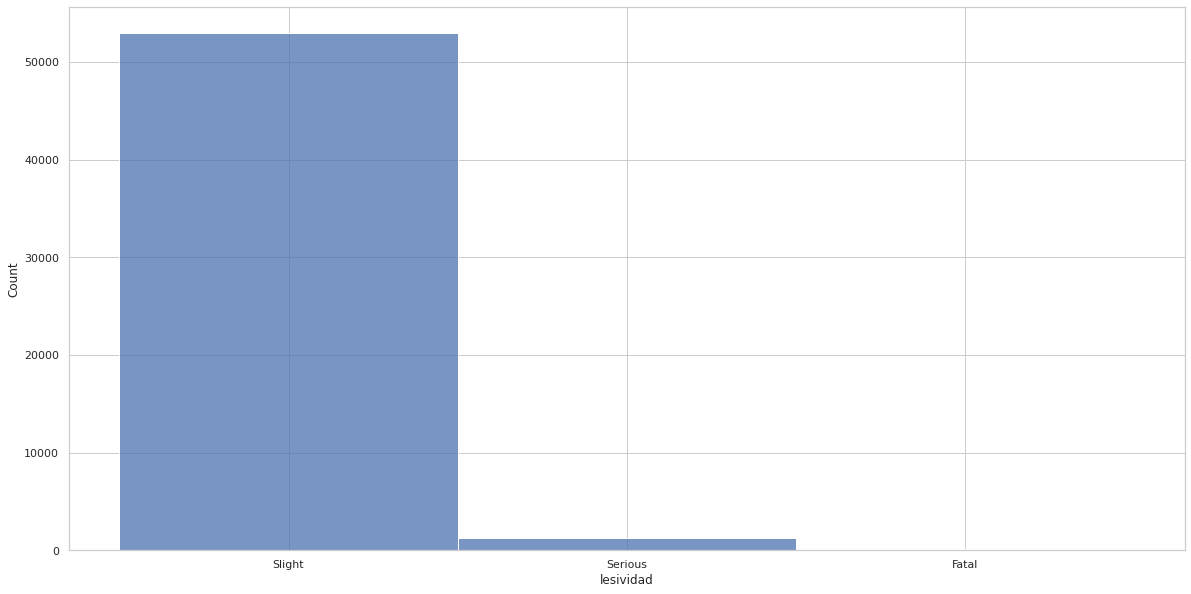

In [34]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(20, 10))

# sns.set_theme(style="whitegrid")
# sns.histplot(data=data_frame, x="lesividad", stat='count')
# # plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
# data_frame.lesividad.value_counts()

<Figure size 432x288 with 0 Axes>

In [391]:
# X_data_frame = data_frame.loc[:, ~data_frame.columns.isin(['lesividad'])]
# Y_data_frame = data_frame['lesividad']

# X_data_frame  = X_data_frame.astype(int)

## Split de datos

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_frame, test_size=0.2)
X_train = train.loc[:, ~train.columns.isin(['lesividad'])]
X_train = X_train.astype(int)
Y_train = train['lesividad']

X_test = test.loc[:, ~test.columns.isin(['lesividad'])]
X_test = X_test.astype(int)
Y_test = test['lesividad']

In [393]:
# # FILE_NAME = f"{city_name}_calculated_weights.json"
# FILE_NAME = 'madrid_adapted_leeds_default_weights.json'

# feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)

In [394]:

# feature_vector = {}

# feature_vector['Accident Features'] = {
#     'feature_childs': ['coordenada_x_utm', 'coordenada_y_utm', 'distrito', 'hora', 'vehiculos_implicados'],
#     'feature_weights': [0.165774538, 0.171530785, 0.082228259, 0.047771472, 0.060763375]
# } 

# feature_vector['Roadway Features'] = {
#     'feature_childs': ['tipo_accidente'], # Road Surface 
#     'feature_weights': [0.07036541]
# }

# feature_vector['Environmental Features'] = {
#     'feature_childs': ['estado_meteorológico'],
#     'feature_weights': [0.04354843]
# }

# feature_vector['Vehicle Features'] = {
#     'feature_childs': ['tipo_vehiculo'],
#     'feature_weights': [0.126314657]
# }

# feature_vector['Casualty Features'] = {
#     'feature_childs': ['tipo_persona', 'sexo', 'rango_edad', 'drogas_alcohol_positivo'],
#     'feature_weights': [0.067057589, 0.049116389, 0.095220163, 0.059951354]
# } 
# matrix_indexes = fv2gi(feature_vector)

# # {'Accident Features': {'feature_childs': ['Easting',
# #    'Northing',
# #    '1st Road Class',
# #    'Accident Time',
# #    'Number of Vehicles'],
# #   'feature_weights': [0.165774538,
# #    0.171530785,
# #    0.082228259,
# #    0.047771472,
# #    0.060763375],
# #   'wpi': 0.528068429},
# #  'Roadway Features': {'feature_childs': ['Road Surface'],
# #   'feature_weights': [0.048847406],
# #   'wpi': 0.048847406},
# #  'Environmental Features': {'feature_childs': ['Lighting Conditions',
# #    'Weather Conditions'],
# #   'feature_weights': [0.041826936, 0.04354843],
# #   'wpi': 0.08537536600000001},
# #  'Vehicle Features': {'feature_childs': ['Type of Vehicle'],
# #   'feature_weights': [0.126314657],
# #   'wpi': 0.126314657},
# #  'Casualty Features': {'feature_childs': ['Casualty Class',
# #    'Sex of Casualty',
# #    'Age of Casualty'],
# #   'feature_weights': [0.067057589, 0.049116389, 0.095220163],
# #   'wpi': 0.211394141}}
# feature_vector

## Normalización de datos

In [46]:
X_train = X_train.astype(int)
X_test  = X_test.astype(int)

X_train = normalize_data(X_train)
X_test  = normalize_data(X_test)

## Oversampling de datos

In [47]:
print('********** Before OverSampling **********')
print('Slight: ', (Y_train == 'Slight').sum())
print('Serious:', (Y_train == 'Serious').sum())
print('Fatal:  ', (Y_train == 'Fatal').sum())
print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

X_train, Y_train = oversample_data(X_train, Y_train)

********** Before OverSampling **********
Slight:  42477
Serious: 1039
Fatal:   67

 Total X: 43583  Total Y: 43583 

********** After OverSampling **********
Slight:  42477
Serious: 42476
Fatal:   42477

 Total X:  127430  Total Y:  127430


## Downsampling de datos

In [397]:
from sklearn.model_selection import train_test_split

from sklearn.utils import resample

slight_data  = test[test['lesividad'] == 'Slight']
serious_data = test[test['lesividad'] == 'Serious']
fatal_data   = test[test['lesividad'] == 'Fatal']

X_slight_downsampled = resample(slight_data,
                                replace = True,
                                n_samples = len(fatal_data))

X_serious_downsampled = resample(serious_data,
                                 replace = True,
                                 n_samples = len(fatal_data))


downsampled_dataset = pd.concat([X_slight_downsampled, X_serious_downsampled, fatal_data])

downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.3)

X_train_downsampled = downsampled_train.loc[:, ~downsampled_train.columns.isin(['lesividad'])]
Y_train_downsampled = downsampled_train['lesividad']

X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin(['lesividad'])]
Y_test_downsampled = downsampled_test['lesividad']

In [398]:
X_train = X_train.astype(int)
X_test  = X_test.astype(int)
X_train_downsampled = X_train_downsampled.astype(int)
X_test_downsampled  = X_test_downsampled.astype(int)

X_train = normalize_data(X_train)
X_test  = normalize_data(X_test)
X_train_downsampled = normalize_data(X_train_downsampled)
X_test_downsampled  = normalize_data(X_test_downsampled)

## XGBoost

In [399]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Genético

In [400]:
# HYPERPARAMS_TO_OPTIMIZE = {'eta': {'type': 'float',
#                                    'init': [0.01, 1],
#                                    'mutation': [-0.3, 0.3],
#                                    'round': 2
#                                    },
#                            'max_depth': {'type': 'int',
#                                          'init': [1, 20],
#                                          'mutation': [-4, 4],
#                                          'step': 1
#                                    },
#                            'min_child_weight': {'type': 'float',
#                                                 'init': [0.1, 15.0],
#                                                 'mutation': [-5, 5],
#                                                 'round': 1
#                                    },
#                            'n_estimators': {'type': 'int',
#                                             'init': [0, 2000],
#                                             'mutation': [-200, 200],
#                                             'step': 150
#                                    },
# }

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


This is number 0 generation
New population is 0
Best F1 score in the this iteration = 0.5714, best solution [2.00e-01 4.00e+00 6.60e+00 3.77e+02]
9 min_child_weight 1.0
12 eta -0.1
12 min_child_weight -2.9
16 min_child_weight -1.0
18 min_child_weight 3.2
32 eta 0.22
34 min_child_weight -4.5
37 min_child_weight -1.3
38 n_estimators -75
38 min_child_weight -0.5
58 eta 0.3
61 max_depth -2
61 eta 0.0
This is number 1 generation
New population is 22
Best F1 score in the this iteration = 0.5714, best solution [4.00e-02 2.00e+00 6.80e+00 3.59e+02]
6 n_estimators 25
6 eta -0.23
22 n_estimators 100
29 n_estimators 0
29 max_depth 5
30 n_estimators -75
31 eta 0.28
33 min_child_weight 1.1
39 max_depth -5
43 min_child_weight -1.1
47 min_child_weight 1.5
49 n_estimators -50
52 n_estimators 100
59 max_depth 2
62 min_child_weight -1.9
63 min_child_weight 0.9
This is number 2 generation
New population is 32
Best F1 score in the this iteration = 0.5714, best solution [4.00e-02 2.00e+00 6.80e+00 3.59e+02

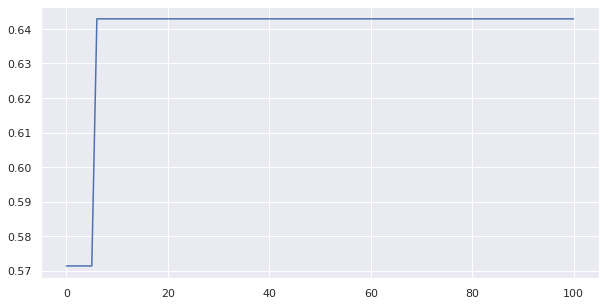

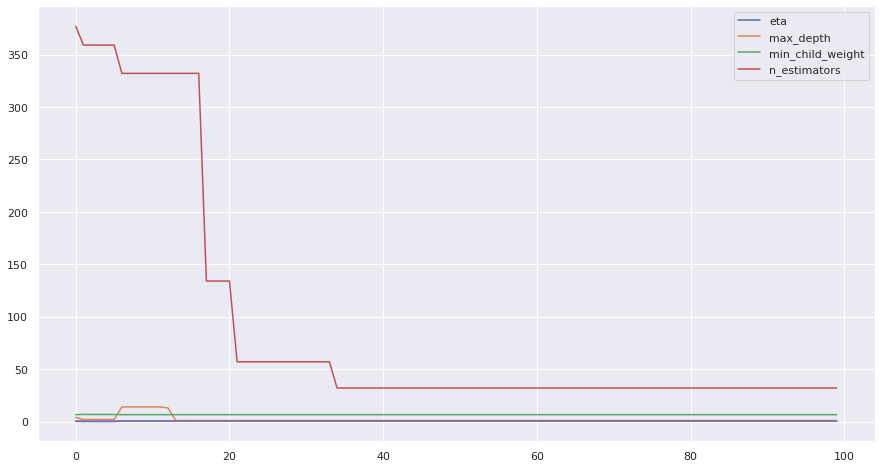

In [405]:
# import xgboost as xgb
# import random

# Y_train_onehot = casualty_to_one_hot(Y_train)
# Y_test_onehot  = casualty_to_one_hot(Y_test)

# Y_train_downsampled_onehot = casualty_to_one_hot(Y_train_downsampled)
# Y_test_downsampled_onehot  = casualty_to_one_hot(Y_test_downsampled)


# # number_of_individuals = 60
# # numberOfParentsMating = 15
# # number_of_hyperparams = len(HYPERPARAMS_TO_OPTIMIZE)
# # number_of_generations = 100

# populationSize = (number_of_individuals, number_of_hyperparams)
# population = initilialize_population(number_of_individuals   = number_of_individuals,
#                                      hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

# fitnessHistory = np.empty([number_of_generations+1, number_of_individuals]) # Define an array to store the value of each parameter for each parent and generation
# populationHistory = np.empty([(number_of_generations+1)*number_of_individuals, number_of_hyperparams]) # Insert the value of initial parameters in history

# best_solution_history = np.empty([(number_of_generations), number_of_hyperparams+1])
# populationHistory[0:number_of_individuals,:] = population


# xgbDMatrixTrain = xgb.DMatrix(data  = X_train_downsampled,
#                               label = Y_train_downsampled)

# xgbDMatrixTest  = xgb.DMatrix(data  = X_test_downsampled, 
#                               label = Y_test_downsampled)

# for generation in range(number_of_generations):

#     print("This is number %s generation" % (generation))

#     new_population = []
    
#     unique_individuals = np.unique(population, axis=0)
    
#     new_individuals_to_create = number_of_individuals - len(unique_individuals)
    
#     for i in range(new_individuals_to_create):
#         new_individual = generate_individual(hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)
#         new_population.append(new_individual)
    
#     new_population = np.array(new_population)

#     if (new_individuals_to_create):
#         population = np.concatenate((unique_individuals, new_population), axis=0)

#     # print(f'Current population is {population}')
#     print(f'New population is {len(new_population)}')
    
#     # Train the dataset and obtain fitness
#     fitnessValue = train_population(population = population,
#                                     hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
#                                     dMatrixTrain = xgbDMatrixTrain,
#                                     dMatrixTest = xgbDMatrixTest,
#                                     Y_test = Y_test_downsampled)
 
#     fitnessHistory[generation,:] = fitnessValue

#     # Best score in the current iteration
#     max_score_index = np.argmax(fitnessHistory[generation,:])
#     max_score_value = np.max(fitnessHistory[generation,:])
#     max_score_solution = population[max_score_index]

#     max_solution_with_score = []
#     max_solution_with_score = np.append(max_score_solution, max_score_value)
#     best_solution_history[generation] = max_solution_with_score

#     print(f"Best F1 score in the this iteration = {max_score_value}, best solution {max_score_solution}") # Survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected
    
#     parents = new_parents_selection(population = population,
#                                     fitness = fitnessValue,
#                                     numParents = numberOfParentsMating)
    
#     # Mate these parents to create children having parameters from these parents (we are using uniform crossover)
#     children = crossover_uniform(parents = parents,
#                                  childrenSize = (populationSize[0] - parents.shape[0], number_of_hyperparams))
    
#     # Add mutation to create genetic diversity
#     children_mutated = mutation(children,
#                                 hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)
    
#     '''
#     We will create new population, which will contain parents that where selected previously based on the
#     fitness score and rest of them  will be children
#     '''
#     population[0:parents.shape[0], :] = parents # Fittest parents
#     population[parents.shape[0]:, :]  = children_mutated # Children
    
#     populationHistory[(generation+1)*number_of_individuals : (generation+1)*number_of_individuals + number_of_individuals , :] = population # Store parent information
    
# #Best solution from the final iteration

# fitness = train_population(population = population,
#                            hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
#                            dMatrixTrain = xgbDMatrixTrain,
#                            dMatrixTest = xgbDMatrixTest,
#                            Y_test = Y_test_downsampled)

# fitnessHistory[generation+1, :] = fitness # index of the best solution
# bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]


# best_hyperparams = {}
# for n_param, hyperparam in enumerate(HYPERPARAMS_TO_OPTIMIZE):
#     best_hyperparams[hyperparam] = population[bestFitnessIndex][n_param]

# #### PLOT FITNESS EVOLUTION ####
# x_fitness = [np.max(fitnessHistory[i]) for i in range(0,fitnessHistory.shape[0])]

# FILE_NAME = 'madrid_ga_' + MODEL_TIMESTAMP  + '.jpg'

# plt.figure(figsize=(10, 5))
# plt.plot(np.arange(len(x_fitness)), x_fitness)
# plt.savefig(GA_SCORES_PATH + FILE_NAME)

# #### PLOT HYPERPARAMS EVOLUTION ####
# FILE_NAME = f"madrid_ga_hyperparams_evolution_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.jpg"

# LEGEND_LABELS = HYPERPARAMS_TO_OPTIMIZE.keys()

# plt.figure(figsize=(15, 8))
# plt.plot(best_solution_history)
# plt.legend(LEGEND_LABELS)
# plt.savefig(HYPERPARAMS_EVOLUTON_PATH + FILE_NAME, dpi=300)

# FILE_NAME = f"madrid_population_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.txt"

# np.savetxt(FINAL_POPULATION_PATH + FILE_NAME, population, fmt='%s')

### Hiperparámetros

- [Bayesian Optimization with HYPEROPT](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook)

#### Carga hiperparámetros

In [ ]:
FILE_NAME = 'madrid_hyperparams2022-04-28-19:07:55.json'

best_hyperparams = load_json(HYPERPARAMS_PATH, FILE_NAME)

# 0.875 GA
# 0.04, 1, 3.9, 900
# best_hyperparams = {}
# best_hyperparams['eta'] = 0.04
# best_hyperparams['max_depth'] = 1
# best_hyperparams['min_child_weight'] = 3.9
# best_hyperparams['n_estimators'] = 900

#### Cálculo de Hiperparámetros

In [ ]:
# Y_train_onehot = casualty_to_one_hot(Y_train)
# Y_test_onehot  = casualty_to_one_hot(Y_test)

# space={'max_depth': hp.quniform("max_depth", 3, 20, 1),
#         'gamma': hp.uniform ('gamma', 1,8),
#         'reg_alpha' : hp.quniform('reg_alpha', 40, 150, 1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 15, 1),
#         'n_estimators': hp.quniform('n_estimators', 100, 200, 100),
#         'tree_method': 'gpu_hist'
#     }

# def objective(space):
#     clf = XGBClassifier(n_estimators = int(space['n_estimators']),
#                         max_depth = int(space['max_depth']),
#                         gamma = space['gamma'],
#                         reg_alpha = int(space['reg_alpha']),
#                         min_child_weight = int(space['min_child_weight']),
#                         colsample_bytree = int(space['colsample_bytree']),
#                         tree_method = space['tree_method']
#                        )
    
#     evaluation = [(X_train, Y_train), (X_test, Y_test)]
    
#     clf.fit(X_train, Y_train,
#             eval_set = evaluation, eval_metric = "auc",
#             early_stopping_rounds = 10, verbose = False)
            
    
#     pred = clf.predict(X_test)
#     accuracy = accuracy_score(Y_test, pred>0.5)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }


# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 200,
#                         trials = trials)

#### Escritura hiperparámetros

In [406]:
# FILE_NAME = 'madrid_hyperparams' + MODEL_TIMESTAMP + '.json'

# write_json(best_hyperparams, HYPERPARAMS_PATH, FILE_NAME)
# print(best_hyperparams)

{'eta': 0.32, 'max_depth': 1.0, 'min_child_weight': 6.6, 'n_estimators': 32.0}


### Pesos de características

#### Carga definitiva/auxiliar de pesos

In [ ]:
# FILE_NAME = 'madrid_adapted_leeds_default_weights.json'
FILE_NAME = 'madrid_weights_no_roadClass.json'
# FILE_NAME = 'madrid_weights2022-04-14-11:16:13.json'

feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)
feature_vector

#### Cálculo de pesos de caracetrísticas

In [ ]:
xgboost = XGBClassifier(best_hyperparams,
                        tree_method = 'gpu_hist',
                        single_precision_histogram =  True)

xgboost.fit(X_train, Y_train)

child_weights  = np.array(xgboost.feature_importances_)
feature_vector = fill_feature_vector(X_train, child_weights)

#### Visualización pesos calculados

In [ ]:
FILE_NAME = f"{city_name}_figure_weights_{MODEL_TIMESTAMP}.jpg"

print(xgboost.get_booster().get_score(importance_type= 'weight'))
plt.figure(figsize=(10, 5))
plt.barh(X_train.columns, xgboost.feature_importances_)
plt.savefig(WEIGHTS_PATH + FILE_NAME)

print(xgboost.feature_importances_)

for column, weight in zip(X_train.columns,xgboost.feature_importances_):
  print(column, weight)

child_weights  = np.array(xgboost.feature_importances_)
feature_vector = fill_feature_vector(X_train, child_weights)
# display(feature_vector)

#### Escritura de pesos de características

- v5: Pesos calculados con hiperparámetros. En el dataset están tipificados los vehículos como en el artículo, las edades no están en rango.
- v6: Pesos calculados con hiperparámetros. En el dataset están tipificados los vehículos como en el artículo, las edades están en rango.
- v7: hiperparams, tipos de carretera tipificados por vía.

In [ ]:
matrix_indexes = fv2gi(feature_vector)

FILE_NAME = f"{city_name}_weights{MODEL_TIMESTAMP}.json"
# FILE_NAME = 'default_calculated_weights.json'

write_json(feature_vector, WEIGHTS_PATH, FILE_NAME)

### Cálculo índices de matriz

In [ ]:
matrix_indexes = fv2gi(feature_vector)

## Construcción de imágenes

In [ ]:
train_bgi = build_gray_images(X_train, 5, matrix_indexes)
test_bgi  = build_gray_images(X_test, 5, matrix_indexes)

pd.DataFrame(train_bgi[:,:,1057])

## Reshape de imágenes

In [ ]:
train_images = shape_images(X_data = X_train,
                            gray_images = train_bgi)
test_images  = shape_images(X_data = X_test,
                            gray_images = test_bgi)

plt.gray()
for i in range(0,3):
    plt.figure(figsize=(3, 3))
    plt.imshow(train_bgi[:,:,i])
    plt.show()

In [ ]:
# train_images = shape_images(X_data = X_train,
#                             gray_images = train_bgi)
# test_images  = shape_images(X_data = X_test,
#                             gray_images = test_bgi)

## One-Hot

In [ ]:
Y_train_onehot = casualty_to_one_hot(Y_train)
Y_test_onehot  = casualty_to_one_hot(Y_test)

array_train_images = np.asarray(train_images)
array_test_images  = np.asarray(test_images)

## Visualización de datos

In [ ]:
# !conda install -c anaconda seaborn --y

### Matriz de correlación

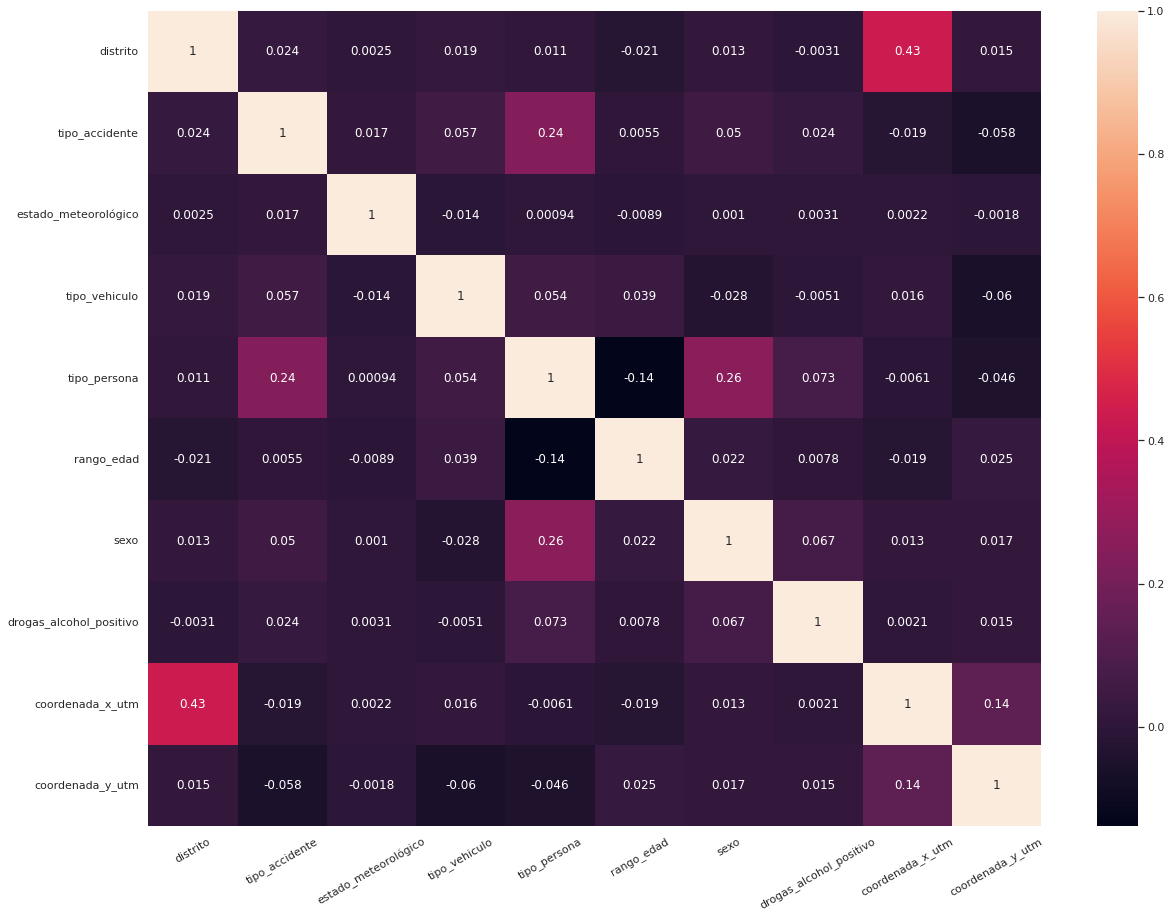

In [57]:
correlation_matrix(data_frame, file)

### PCA

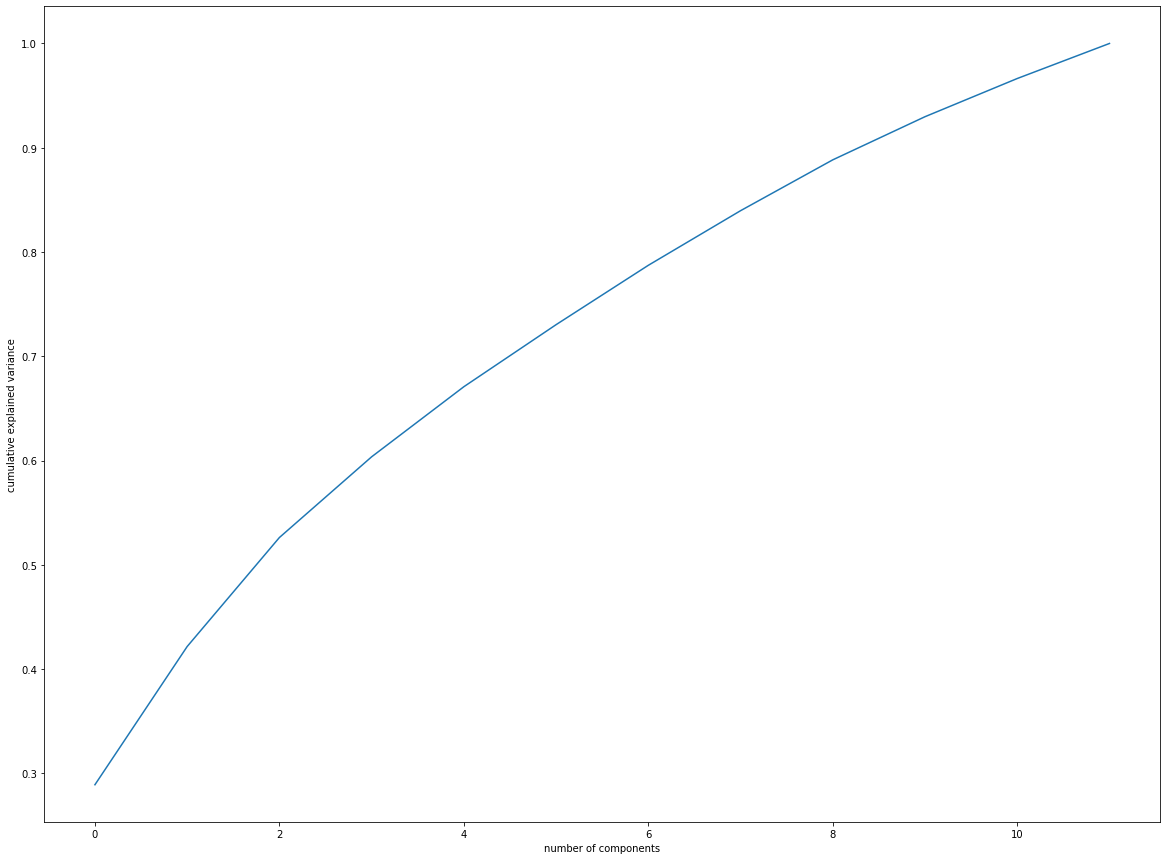

In [57]:
pca(X_train, X_test)

### TSNE

In [ ]:
# output_file_name = './2d_test_tsne.jpg'
# plot_TSNE(X_test, Y_test, n_components=2)

# output_file_name = './2d_train_tsne.jpg'
# plot_TSNE(X_train, Y_train, n_components=2)

# output_file_name = './3d_test_tsne.jpg'
# plot_TSNE(X_test, Y_test, n_components=3)

# output_file_name = './3d_train_tsne.jpg'
# plot_TSNE(X_train, Y_train, n_components=3)

### Autoencoder

#### Entrenamiento

In [ ]:
# input_img = Input(shape=(25,))

# # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
# encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
# encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

# # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
# decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
# decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

# # this model maps an input to its reconstruction
# autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
# autoencoder.summary()

# autoencoder.compile(optimizer='adam', loss='binary_crossentropy') #se usan estos dos en estas arquitecturas

X_train = array_train_images
X_test = array_test_images

X_train = X_train.reshape(len(array_train_images), 25)
X_test  = X_test.reshape(len(X_test), 25)

# autoencoder.fit(X_train, X_train,
#                 epochs=15,
#                 batch_size=32,
#                 shuffle=True,
#                 validation_data=(X_test, X_test))

#### Visualización

In [ ]:
# # create encoder model
# encoder = tf.keras.Model(inputs=input_img, outputs=encoder2)
# encoder.summary()
# # create decoder model
# encoded_input = Input(shape=(3,))
# #lo que hace aqui es quedarse con las capas que corresponden al decodificador
# decoder_layer1 = autoencoder.layers[-2]
# decoder_layer2 = autoencoder.layers[-1]
# decoder = tf.keras.Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))
# decoder.summary()
# # si miramos la salida, son simetricos el uno respecto al otro
# # encoder va de input a 3 y decoder de 3 a input

# # get latent vector for visualization
# latent_vector = encoder.predict(X_test)
# # get decoder output to visualize reconstructed image
# reconstructed_imgs = decoder.predict(latent_vector)


# # visualize in 3D plot
# from pylab import rcParams
# from mpl_toolkits.mplot3d import Axes3D

# rcParams['figure.figsize'] = 10, 8

# fig = plt.figure(1)
# ax = Axes3D(fig)

# xs = latent_vector[:, 0]
# ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# # color=['red','green','blue']

# # for x, y, z, label in zip(xs, ys, zs, Y_test):
# #     c = color[int(label)]
# #     ax.text(x, y, z, label, backgroundcolor=c)
    
# # ax.set_xlim(xs.min(), xs.max())
# # ax.set_ylim(ys.min(), ys.max())
# # ax.set_zlim(zs.min(), zs.max())

# # plt.show()

# # X_test_encoded = encoder.predict(X_test, batch_size=32)
# # plt.figure(figsize=(6, 6))
# # plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# # plt.colorbar()
# # plt.show()

## Models

In [71]:
array_train_images = np.asarray(train_images)
array_test_images  = np.asarray(test_images)

input_train_shape = (len(array_train_images), 5, 5, 1)
input_test_shape  = (len(array_test_images), 5, 5, 1)

array_train_images = array_train_images.reshape(input_train_shape)
array_test_images  = array_test_images.reshape(input_test_shape)

NameError: name 'train_images' is not defined

### KNN

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

MODEL_NAME = MODELS_NAME[0]

#### Entrenamiento

In [ ]:
# # leaf_size = list(range(1,10, 2))
# # n_neighbors = list(range(1,100, 10))
# # p = [1, 2]

# # Create new KNN object
# hyperparameters = dict(leaf_size = leaf_size,
#                        n_neighbors = n_neighbors)

# # Use GridSearch
# knn_2 = KNeighborsClassifier()

# # Fit the model
# clf = GridSearchCV(knn_2,
#                    hyperparameters,
#                    cv = 4)

# knn = clf.fit(X_train, Y_train)

# # Print The value of best Hyperparameters

# best_leaf_size = knn.best_estimator_.get_params()['leaf_size']
# best_n_neighbors = knn.best_estimator_.get_params()['n_neighbors']

# print('Best leaf_size:', best_leaf_size)
# print('Best n_neighbors:', best_n_neighbors)

# df = pd.DataFrame({'best_leaf_size':[best_leaf_size], 'n_neighbors':[best_n_neighbors]})

# FILE_NAME = f"{MODEL_NAME}/madrid_{MODEL_TIMESTAMP}.csv"

# df.to_csv(HYPERPARAMS_PATH + FILE_NAME, index = True)

#### Escritura del modelo

In [ ]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.pkl"

# # Its important to use binary mode 
# knnPickle = open(MODEL_PATH + MODEL_FILE_NAME, 'wb') 

# # source, destination 
# pickle.dump(knn, knnPickle)

#### Carga de modelo pre-entrenado

In [ ]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_2022-04-27-21:50:26.pkl"

# # load the model from disk
# loaded_model = pickle.load(open(MODEL_PATH + MODEL_FILE_NAME, 'rb'))

#### Resultados

In [ ]:
# y_true = tf.argmax(Y_test_onehot, axis=1)
# y_predicted = knn.predict(X_test)

# Y_test_labels = one_hot_to_casualty(Y_test)

# ############## SAVE CLASSIFICATION REPORT ##############
# report = classification_report(y_true,
#                                y_predicted,
#                                target_names = Y_test_labels.unique(),
#                                output_dict = True)

# REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
# REPORT_NAME  = f"{city_name}_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

# report_df = pd.DataFrame(report).transpose()
# report_df.to_csv(REPORT_PATH + REPORT_NAME, index= True)


# ############## SAVE CONFUSION MATRIX ##############

# CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
# CONFUSION_MATRIX_NAME  = f"{city_name}_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.jpg"

# cm = confusion_matrix(y_true,
#                       y_predicted,
#                       labels = Y_test.unique())

# disp = ConfusionMatrixDisplay(confusion_matrix = cm,
#                               display_labels = Y_test_labels.unique()).plot()

# plt.savefig(CONFUSION_MATRIX_PATH + CONFUSION_MATRIX_NAME, dpi = 150)

### Convolution 1D

In [ ]:
MODEL_NAME = MODELS_NAME[1]

#### Entrenamiento

In [ ]:
# history = convolution_1d.fit(array_train_images, Y_train_onehot,
#                              batch_size = 128, epochs = 100, shuffle = True,
#                              validation_data = (array_test_images, Y_test_onehot))
# # history

#### Escritura del modelo

In [ ]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

# tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [ ]:
MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = 'madrid_convolution_1d_2022-05-11-08:53:52.h5'

convolution_1d = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [ ]:
from sklearn.metrics import classification_report

Y_test_labels = one_hot_to_casualty(Y_test)

########################################################################

F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.jpg"

# ## Plot history: F1 SCORE
# figure_name = plt.figure(figsize=(20, 10))
# plt.plot(history.history['f1_score'], label='F1 score (training data)')
# plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
# plt.title('F1 score')
# plt.ylabel('F1 score value')
# plt.xlabel('No. epoch')
# plt.legend(loc="upper left")
# plt.savefig(F1_SCORE_PATH + F1_SCORE_NAME)
# plt.show()

# print(history)

########################################################################

# evaluate the network
print("[INFO] evaluating network...")
predictions = tasp_cnn.predict(x=array_test_images, batch_size=128)

report = classification_report(tf.argmax(Y_test_onehot, axis=1),
                               predictions.argmax(axis=1),
                               target_names = Y_test_labels.unique(),
                               output_dict = True)

REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
REPORT_NAME  = f"{city_name}_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

report_df = pd.DataFrame(report).transpose()
report_df.to_csv(REPORT_PATH + REPORT_NAME, index= True)

# display(report_df)

############## SAVE CONFUSION MATRIX ##############
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
CONFUSION_MATRIX_NAME  = f"{city_name}_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.jpg"

y_true = tf.argmax(Y_test_onehot, axis=1)
y_predicted = predictions.argmax(axis=1)

cm = confusion_matrix(y_true, y_predicted, labels = Y_test.unique())

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = Y_test_labels.unique()).plot()

plt.savefig(CONFUSION_MATRIX_PATH + CONFUSION_MATRIX_NAME, dpi = 150)

### Convolution 2D

In [ ]:
MODEL_NAME = MODELS_NAME[2]

#### Entrenamiento

In [ ]:
# history = tasp_cnn.fit(array_train_images, Y_train_onehot,
#                        batch_size = 128, epochs = 100, shuffle = True,
#                        validation_data = (array_test_images, Y_test_onehot))
# # history

#### Escritura del modelo

In [ ]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

# tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [ ]:
MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = 'madrid_convolution_2d_2022-05-11-08:53:52.h5'

tasp_cnn = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [ ]:
from sklearn.metrics import classification_report

Y_test_labels = one_hot_to_casualty(Y_test)

########################################################################

F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.jpg"

## Plot history: F1 SCORE
figure_name = plt.figure(figsize=(20, 10))
plt.plot(history.history['f1_score'], label='F1 score (training data)')
plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
plt.title('F1 score')
plt.ylabel('F1 score value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.savefig(F1_SCORE_PATH + F1_SCORE_NAME)
plt.show()

print(history)

########################################################################

# evaluate the network
print("[INFO] evaluating network...")
predictions = tasp_cnn.predict(x=array_test_images, batch_size=128)

report = classification_report(tf.argmax(Y_test_onehot, axis=1),
                               predictions.argmax(axis=1),
                               target_names = Y_test_labels.unique(),
                               output_dict = True)

REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
REPORT_NAME  = f"{city_name}_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

report_df = pd.DataFrame(report).transpose()
report_df.to_csv(REPORT_PATH + REPORT_NAME, index= True)

# display(report_df)

############## SAVE CONFUSION MATRIX ##############
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
CONFUSION_MATRIX_NAME  = f"{city_name}_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.jpg"

y_true = tf.argmax(Y_test_onehot, axis=1)
y_predicted = predictions.argmax(axis=1)

cm = confusion_matrix(y_true, y_predicted, labels = Y_test.unique())

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = Y_test_labels.unique()).plot()

plt.savefig(CONFUSION_MATRIX_PATH + CONFUSION_MATRIX_NAME, dpi = 150)

In [ ]:
# tasp_cnn.save(root_path + 'madrid_model_XGBOOST_predicted.h5')

# Data Summary

In [ ]:
# MODEL_TIMESTAMP

# WEIGHTS_PATH  = './feature_weights/'
# REPORTS_PATH  = 'Reports/'
# MODELS_PATH   = 'Models/'
# F1_SCORES_PATH = 'F1scores/'
# GA_SCORES_PATH = 'GA_Scores/'
# HYPERPARAMS_PATH = './hyperparams/'

# HYPERPARAMS_EVOLUTON_PATH = './hyperparams_evolution/'
# FINAL_POPULATION_PATH = './population/'
# CONFUSIONS_MATRIX_PATH = 'confusion_matrix/'

# ###### MODELS ######
# MODELS_NAME = ['knn', 'convolution_1d', 'convolution_2d']
# DATA_PATHS = [REPORTS_PATH]

from os.path import exists

reports_summary = pd.DataFrame()

cities = ['leeds', 'madrid']

models_renaming = {'knn': 'KNN',
                   'convolution_1d': '1D-convolution',
                   'convolution_2d': '2D-convolution'}

for model_name in MODELS_NAME:
    
    REPORT_PATH = f"{REPORTS_PATH}{model_name}/"

    for city in cities:
        REPORT_NAME  = f"{city}_{model_name}_report_{MODEL_TIMESTAMP}.csv"

        if exists(REPORT_PATH + REPORT_NAME):
            report = pd.read_csv(REPORT_PATH + REPORT_NAME, index_col=[0])
            report.insert(0, 'city', city)
            report.insert(1, 'model', models_renaming[model_name])
            
            reports_summary = pd.concat([reports_summary, report])

reports_summary = reports_summary.sort_values(['city', 'model'], ascending = [True, True])

c_m = reports_summary['city'] + '_' + reports_summary['model']
reports_summary.insert(0, 'c_m', c_m)

# reports_summary.drop(['city', 'model'], axis=1, inplace = True)

SAVE_PATH =  f"{REPORTS_SUMMARY_PATH}{MODEL_TIMESTAMP}.csv"

reports_summary.to_csv(SAVE_PATH, index= True)

reports_summary.insert(0, 'accident_type', reports_summary.index)

In [ ]:
import seaborn as sns

MEASURE_TYPES  = ['precision', 'recall', 'f1-score']
ACCIDENT_TYPES = ['Slight', 'Serious', 'Fatal']

fig, axs = plt.subplots(len(MEASURE_TYPES), len(cities), figsize=(15,10))

leeds_reports_summary  = reports_summary[reports_summary['city'] == 'leeds']
madrid_reports_summary = reports_summary[reports_summary['city'] == 'madrid']

# print(leeds_reports_summary.loc[ACCIDENT_TYPES])

for index, measure_type in enumerate(MEASURE_TYPES):

    ax = sns.barplot(x = 'accident_type',
                     y = measure_type,
                     hue = 'model',
                     data = leeds_reports_summary.loc[ACCIDENT_TYPES],
                     ax = axs[index, 0]).set(title = f"{measure_type} Leeds")

    ax = sns.barplot(x = 'accident_type',
                     y = measure_type,
                     hue = 'model',
                     data = madrid_reports_summary.loc[ACCIDENT_TYPES],
                     ax = axs[index, 1]).set(title = f"{measure_type} Madrid")

SAVE_PATH = f"{REPORTS_SUMMARY_PATH}{MODEL_TIMESTAMP}.png"

fig = fig.get_figure()
fig.savefig(SAVE_PATH)